In [1]:
import glob
import os
import shutil

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from pipeline.python.utils import convert_range
import scipy.stats as spstats


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

import traceback
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.paradigm import utils as par_utils
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics
from pipeline.python.coregistration import align_fov as coreg

import json
import tifffile as tf
from scipy import ndimage


import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.colors as mcolors
import cPickle as pkl
import h5py

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import rf_utils as rfutils

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from sklearn.model_selection import train_test_split
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

import seaborn as sns

In [3]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [4]:
%matplotlib inline

In [5]:
def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1,
                               is_circular=False, vmin=-np.pi, vmax=np.pi):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array, shape=(d1, d2)
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    #print("no array:", tmpmask.shape, value_array.shape)
    
    # Get full array to average across overlapping pixels, shape=(nrois, d1, d2)?
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    #print("arr:", tmpmask_full.shape, value_array.shape)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        if is_circular:
            avg_mask[ix] = spstats.circmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        else:
            avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

In [6]:
def get_phase_masks(masks, phases, average_overlap=True, roi_list=None, return_absolute=False,
                    use_cont=True, mask_thr=0.01):
    # Convert phase to continuous:
    phases_cont = -1 * phases
    phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = phases.index.tolist()
        
    # Get absolute maps:
    if use_cont:
        elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
        azim = (phases_cont['left'] - phases_cont['right']) / 2.
        vmin = -np.pi
        vmax = np.pi
    else:
        # Get absolute maps:
        elev = (phases['bottom'] - phases['top']) / 2.
        azim = (phases['left'] - phases['right']) / 2.
        
        # Convert to continueous:
        elev_c = -1 * elev
        elev_c = elev_c % (2*np.pi)
        azim_c = -1 * azim
        azim_c = azim_c % (2*np.pi)

        vmin = 0
        vmax = 2*np.pi

        azim = copy.copy(azim_c)
        elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev[roi_list], mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev[roi_list], mask_thr=mask_thr)   
    
    
    if return_absolute:
        return azim_phase, elev_phase, azim, elev
    else:
        return azim_phase, elev_phase



In [7]:
from scipy.interpolate import SmoothBivariateSpline

def fill_and_smooth_nans(img):

    y, x = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    x = x.astype(float)
    y = y.astype(float)
    z = img.copy()
    
    xx = x.copy()
    yy = y.copy()
    xx[np.isnan(z)] = np.nan
    yy[np.isnan(z)] = np.nan

    xx=xx.ravel()
    xx=(xx[~np.isnan(xx)])
    yy=yy.ravel()
    yy=(yy[~np.isnan(yy)])
    zz=z.ravel()
    zz=(zz[~np.isnan(zz)])

#     xnew = np.arange(xx.min(), xx.max()+1) #np.arange(9,11.5, 0.01)
#     ynew = np.arange(yy.min(), yy.max()+1) #np.arange(10.5,15, 0.01)

#     f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
#     znew=np.transpose(f(xnew, ynew)).T

    xnew = np.arange(x.ravel().min(), x.ravel().max()+1) #np.arange(9,11.5, 0.01)
    ynew = np.arange(y.ravel().min(), y.ravel().max()+1) #np.arange(10.5,15, 0.01)
    
    #print(xnew.min(), xnew.max())
    
    f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
    znew=f(xnew, ynew) #).T
    
    znew[np.isnan(z)] = np.nan
    
    #print(z.shape, znew.shape)
    return znew #.T #a


In [8]:
def calculate_gradients(img):
    # Get gradient
    gdy, gdx = np.gradient(img)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(gdx**2 + gdy**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(gradmag)/255
    #gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the x and y gradients
    abs_gdx = np.absolute(gdx)
    abs_gdy = np.absolute(gdy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_gd = np.arctan2(gdy, gdx) # np.arctan2(abs_gdy, abs_gdx) # [-pi, pi]

    # Get mean direction
    #mean_dir = np.rad2deg(np.arctan2(gdy.mean(), gdx.mean())) # TODO why this diff
#     mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())],
#                          low=-np.pi, high=np.pi)) # TODO why this diff
    mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())\
                                               if ((not np.isnan(gy)) and (not np.isnan(gx)))],
                         low=-np.pi, high=np.pi)) # TODO why this diff

    # Get unit vector
    avg_gradient = spstats.circmean(abs_gd[~np.isnan(abs_gd)], low=-np.pi, high=np.pi) #.mean()
    dirvec = (np.cos(avg_gradient), np.sin(avg_gradient))
    vhat = dirvec / np.linalg.norm(dirvec)

    grad_ = {'image': img,
             'magnitude': gradmag,
             'gradient_x': gdx,
             'gradient_y': gdy,
             'direction': abs_gd,
             'mean_deg': mean_dir, # DEG
             'mean_direction': avg_gradient, # RADIANS
             'vhat': vhat}
    
    return grad_


def plot_gradients(grad_, ax=None, draw_interval=3, scale=1, width=0.005, toy=False, headwidth=5):
    '''
    scale:  # of dat units per arrow length unit (smaller=longer arrow)
    scale_units 
    weight = width of plot
    angles='xy' (i.e., arrows point from (x,y) to (x+u, y+v))
    Arrows should point TOWARD larger numbers
    '''
    if ax is None:
        fig, ax = pl.subplots()
        
    gradimg = grad_['image']
    mean_dir = grad_['mean_deg']
    gdx = grad_['gradient_x']
    gdy = grad_['gradient_y']
    
    # Set limits and number of points in grid
    y, x = np.mgrid[0:gradimg.shape[0], 0:gradimg.shape[1]]

    # Every 3rd point in each direction.
    skip = (slice(None, None, draw_interval), slice(None, None, draw_interval))
    
    # plot
    ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k',
              scale=scale, width=width,
              scale_units='xy', angles='xy', pivot='mid', units='width',
              headwidth=headwidth)
    
    gdir_ = grad_['direction'].copy()
    gmean = spstats.circmean(gdir_[~np.isnan(gdir_)], low=-np.pi, high=np.pi)
    
    avg_dir_grad = np.rad2deg(gmean) #np.nanmean(grad_['direction']))
    
    ax.set(aspect=1, title="Mean: %.2f\n(dir: %.2f)" % (mean_dir, avg_dir_grad))

    return ax

In [9]:

def get_retino_metadata(experiment='retino', animalids=None,
                        roi_type='manual2D_circle', traceid=None,
                        rootdir='/n/coxfs01/2p-data', 
                        aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):

    sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
   
    meta_list=[]
    for (animalid, session, fov), g in sdata.groupby(['animalid', 'session', 'fov']):
        if animalids is not None:
            if animalid not in animalids:
                continue
        exp_list = [e for e in g['experiment'].values if experiment in e] 
        if len(exp_list)==0:
            print('skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % experiment,
                                'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retino_run = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                rid_fpath = glob.glob(os.path.join(retino_dir, 'analysisids_*.json'))[0]
                with open(rid_fpath, 'r') as f:
                    retids = json.load(f)
                traceids = [r for r, res in retids.items() if res['PARAMS']['roi_type']==roi_type] 
                for traceid in traceids: 
                    meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))
            else:
                meta_list.append(tuple([animalid, session, fov, retino_run, traceid]))

    return meta_list



## Some aggregate plotting stuff

In [10]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Select dataset

In [11]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'


# Set output dirs

In [12]:
aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Example FOV -------------------------------------------------------------------------------

In [191]:
animalid = 'JC084' #'JC085'
session = '20190522' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'


# Load data

In [194]:
# Load data metainfo
# run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
# RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
# analysis_dir = RETID['DST']
# retinoid = RETID['analysis_id']
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
curr_dst_dir = os.path.join(run_dir, 'retino_analsysis', 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)

FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC084_20190522_FOV1_zoom2p0x_retino_run1_analysis001
Saving output to:
 /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure


# Select colormap

(u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis001_54fab0/retino-structure', 'azimuth_pos_nic_Edge_LEGEND_abs')
(u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis001_54fab0/retino-structure', 'elevation_pos_nic_Edge_LEGEND_abs')


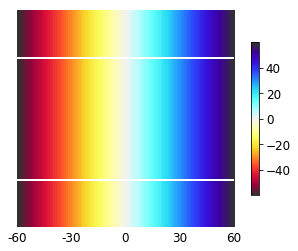

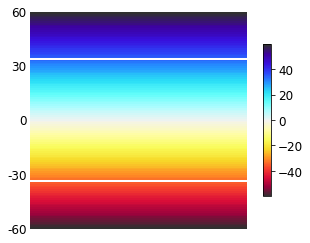

In [193]:
# Load colormap
cmap_name = 'nic_Edge'
zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=zero_center, 
                                                  return_cmap=True, dst_dir=curr_dst_dir)


In [195]:
reload(ret_utils)

<module 'pipeline.python.retinotopy.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.pyc'>

In [196]:
magratio, phase, trials_by_cond = ret_utils.fft_results_by_trial(RETID)

TRIALS BY COND:
{u'top': [11, 1, 7], u'right': [3, 5, 4], u'bottom': [10, 2, 9], u'left': [12, 6, 8]}
('Trials:', [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8])


In [197]:
d2 = scaninfo['pixels_per_line']
d1 = scaninfo['lines_per_frame']
print(d1, d2)

(512, 512)


In [198]:
# Get ROIID and projection image
#masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
#roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
#nrois_total, d1, d2 = masks_soma.shape
print(ds_factor)

2


In [199]:
absolute_el.shape

(256, 256)

In [200]:
pix_mag_thr=0.003
absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
                                                                                 mag_thr=pix_mag_thr, dims=(d1, d2),
                                                                                 plot_conditions=False, ds_factor=ds_factor)


('got phase:', 0.004731791444497091, 6.2798735717757665)
('got absolute:', -2.8137219749084998, 2.6794527825721262)
('Delay:', 0.35276530295739561, 5.7567977498804659)


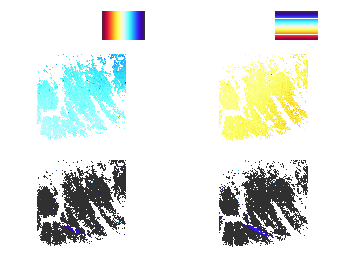

In [201]:
fig = ret_utils.plot_phase_and_delay_maps(absolute_az, absolute_el, delay_az, delay_el,
                                         cmap=cmap_phase, vmin=-np.pi, vmax=np.pi)


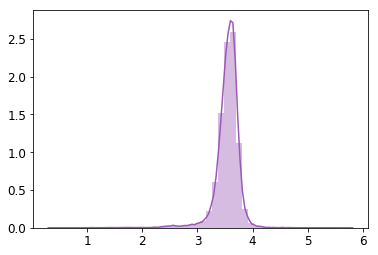

In [202]:
pl.figure()
sns.distplot(delay_az[~np.isnan(delay_az)].ravel())


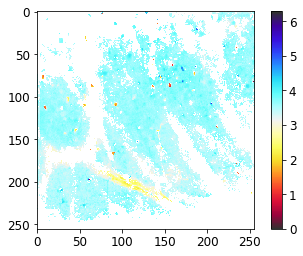

In [203]:
pl.figure()
pl.imshow(delay_az, vmin=0, vmax=2*np.pi, cmap=cmap_phase)
pl.colorbar()

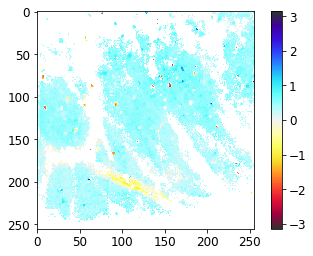

In [204]:
dc = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)
pl.figure()
pl.imshow(dc, vmin=-np.pi, vmax=np.pi, cmap=cmap_phase)
pl.colorbar()

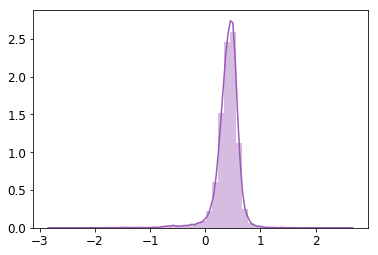

In [205]:
pl.figure()
sns.distplot(dc[~np.isnan(dc)].ravel())


# Shift maps to match

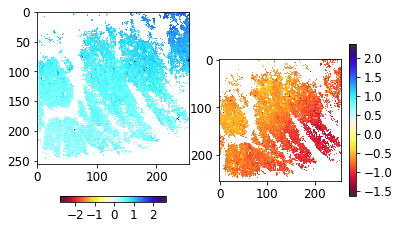

In [208]:
shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)
shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, oldmin=0, oldmax=2*np.pi)


np.where(abs(shift_el_delay)>1)

#filt_az = np.ma.array(absolute_az, mask=abs(shift_az_delay)>1)
#filt_el = np.ma.array(absolute_el, mask=abs(shift_el_delay)>1)

filt_az = np.where(abs(shift_az_delay)<1, absolute_az, np.nan)
filt_el = np.where(abs(shift_el_delay)<1, absolute_el, np.nan)


fig, axn = pl.subplots(1,2)
im0 = axn[0].imshow(filt_az, cmap=cmap_phase) #vmin=-np.pi, vmax=np.pi)
pl.colorbar(im0, ax=axn[0], shrink=0.7, orientation='horizontal')
im1 = axn[1].imshow(filt_el, cmap=cmap_phase) #vmin=-np.pi, vmax=np.pi)
pl.colorbar(im1, ax=axn[1], shrink=0.7, orientation='vertical')


# Smooth

In [209]:
# desired_radius_um = 10.0 #20.0
# pixel_size = putils.get_pixel_size()
# um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)
# pixels2dilate = desired_radius_um/um_per_pixel
# print("Measured pixel size: %s (~%.2fum/pix).\nPixel size with ds_factor %.2f = %i" % (str(pixel_size), um_per_pixel, ds_factor, pixels2dilate))

pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

# zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
# print(zimg.shape, zimg_r.shape)

# pl.figure()
# pl.imshow(zimg_r)

In [210]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(filt_az, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(filt_el, smooth_fwhm=smooth_fwhm)
# if 'zoom1p0x' in fov:
#     print("... resizing")
#     azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
#     elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
azim_smoothed = fill_and_smooth_nans(azim_smoothed)
elev_smoothed = fill_and_smooth_nans(elev_smoothed)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())
print(elev_r[~np.isnan(elev_r)].min(), elev_r[~np.isnan(elev_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()

#azim_r = coreg.transform_2p_fov(azim_phase_mask_np, pixel_size, normalize=False)
#elev_r = coreg.transform_2p_fov(elev_phase_mask_soma, pixel_size, normalize=False)

vmin, vmax = (-np.pi, np.pi)

(0.0, 1.346507024442652)
(-1.1214168503725113, 0.0)


(u'/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure', 'pixelmaps_smooth-7_magthr-0.003')


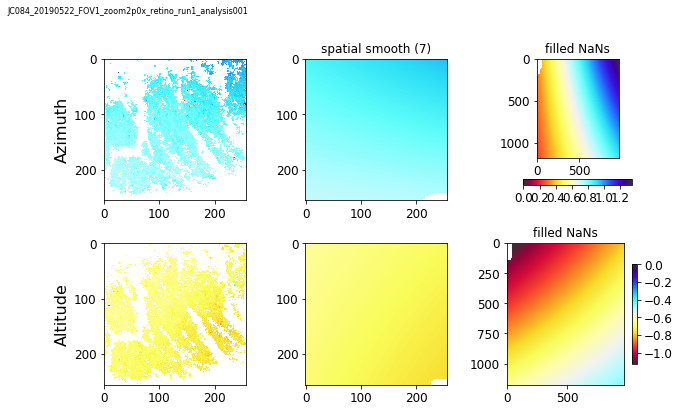

In [211]:
fig, axn = pl.subplots(2,3, figsize=(10,6))

ax = axn[0,0]
ax.imshow(filt_az, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 2]
im0 = ax.imshow(az_fill, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)
#ax.imshow(azim_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 0]
ax.imshow(filt_el, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
im1= ax.imshow(el_fill, cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)

pl.subplots_adjust(wspace=0.3, hspace=0.3)
putils.label_figure(fig, data_id)

figname = 'pixelmaps_smooth-%i_magthr-%.3f' % (smooth_fwhm, pix_mag_thr)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

In [212]:
filt_az

array([[        nan,         nan,         nan, ...,  0.67571363,
         0.37162776,         nan],
       [        nan,         nan,         nan, ...,  1.36560379,
         1.28954456,  1.39502553],
       [        nan,         nan,         nan, ...,         nan,
         1.39472187,  1.49258649],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

# Convert to screen units

In [213]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [214]:
plot_degrees = True

vmin=-np.pi
vmax=np.pi
img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)

# Calculate gradients
if plot_degrees:
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)
else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    # vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(-59.7782, 59.7782)


(u'/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure', 'gradients_smooth-7_degrees_magthr-0.003')


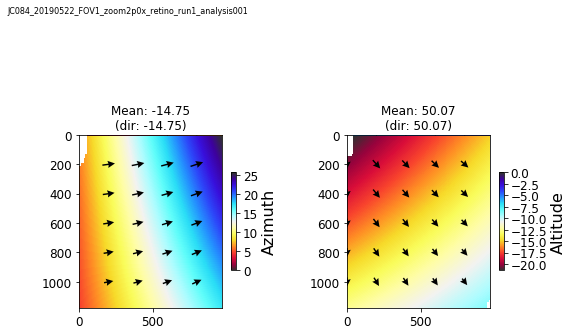

In [215]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_smooth-%i_%s_magthr-%.3f' % (smooth_fwhm, plot_str, pix_mag_thr)

#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

# Unit vector

In [216]:
avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 50.07 deg
[AZ]avg dir: -14.75 deg
(array([ 0.96706322, -0.25453629]), array([ 0.6418901 ,  0.76679665]))


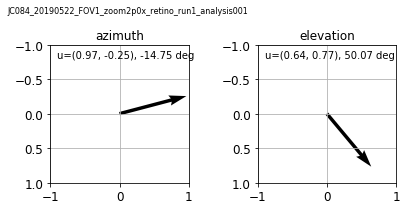

In [217]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'gradients_unitvec_dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


# Project onto retino dir

In [218]:
gimg_az = grad_az['image'].copy()
gimg_el = grad_el['image'].copy()

d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)


# Projected pixel positoins
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

# Retino values
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


(1177, 972)
(array([ 0.96706322, -0.25453629]), array([ 0.6418901 ,  0.76679665]))


#### Test projection cycles

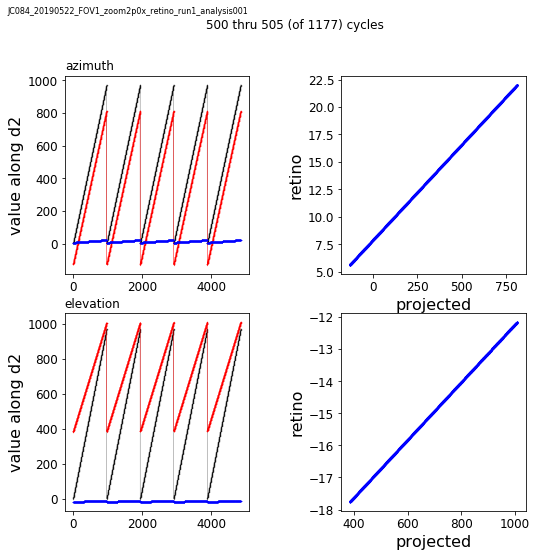

In [219]:
ncyc=5

startcyc=500
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc

fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.set_ylabel('value along d2')

ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Fit

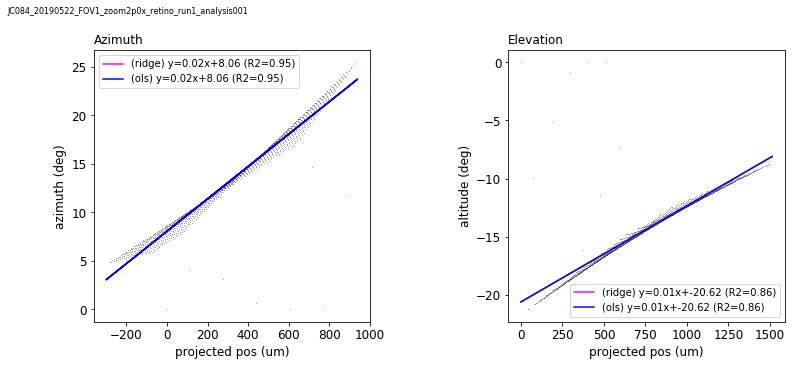

In [220]:
regr_model = 'ridge'
regr_line_color = 'magenta'
regr_model2 = 'ols' 

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

fitv_az2, regr_az2 = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model2)
fitv_el2, regr_el2 = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model2)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=800
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
r2_az = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color=regr_line_color, label=linfit_str)

r2_az2 = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_az2.coef_), float(regr_az2.intercept_), r2_az2) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Azimuth', loc='left')
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color=regr_line_color, label=linfit_str)

r2_el2 = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_el2.coef_), float(regr_el2.intercept_), r2_el2) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Elevation', loc='left')
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s_test' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Compare RF position info

In [221]:
glob.glob(os.path.join(aggregate_dir, 'receptive-fields', 
                                     '%s__%s' % (traceid, rf_fit_desc), 'fits_and_coords*'))

['/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_rfs10.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_drop_repeats_reliable_r_df.pkl']

In [222]:
rf_fit_desc = 'fit-2dgaus_dff-no-cutoff'
rfpos_fpath = glob.glob(os.path.join(aggregate_dir, 'receptive-fields', 
                                     '%s__%s' % (traceid, rf_fit_desc), 'fits_and_coords*'))[1]
print(rfpos_fpath)

with open(rfpos_fpath, 'rb') as f:
    rfpos = pkl.load(f)
    rfpos=rfpos['df']
rfpos.keys()



/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl


Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'datakey_ix', u'fov_xpos', u'fov_xpos_pix', u'fov_ypos',
       u'fov_ypos_pix', u'ml_pos', u'ap_pos'],
      dtype='object')

In [223]:
fovnum=1
datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
curr_rfs = rfpos[rfpos['datakey']==datakey].copy()
print(datakey, curr_rfs.shape)



('20190522_JC084_fov1', (130, 25))


In [224]:
curr_rfs.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fwhm_avg,std_avg,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
1546,0.767913,24.021635,16.906345,0.057323,24.876325,-10.753185,JC084,0,20190522_JC084_fov1,rfs,...,20.463990,8.708081,231.028964,5,345.675,150,19.0372,10,953.763,831.925
1547,0.561637,36.760755,19.990691,6.066365,27.627541,-9.198699,JC084,1,20190522_JC084_fov1,rfs,...,28.375723,12.074776,418.048225,5,207.405,90,79.9562,42,892.844,970.195
1548,0.585081,27.889204,21.404847,6.220339,17.433089,-11.532854,JC084,5,20190522_JC084_fov1,rfs,...,24.647026,10.488096,339.595870,5,202.796,88,196.083,103,776.717,974.804
1549,0.852636,24.879592,20.229131,0.103731,23.867409,-11.367222,JC084,9,20190522_JC084_fov1,rfs,...,22.554361,9.597600,286.308747,5,400.983,174,173.238,91,799.562,776.617
1550,0.526608,17.091075,23.108701,1.607293,24.144343,-11.700484,JC084,10,20190522_JC084_fov1,rfs,...,20.099888,8.553144,224.677234,5,394.07,171,194.179,102,778.621,783.53


In [225]:
rfdf = curr_rfs.copy()
rfdf['ml_proj']=''
rfdf['ap_proj']=''


In [226]:
#retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
#p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
#fpath = p_df['fpath'].unique()[0]
#gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
#with open(gpath, 'rb') as f:
#    gresults = pkl.load(f)

# Project FOV coordinates
rfdf['ml_proj'][rfdf.index] = np.array([np.dot(np.array((ml, ap)), vhat_az) \
                                      for ap, ml in curr_rfs[['ap_pos', 'ml_pos']].values])
rfdf['ap_proj'][rfdf.index] = np.array([np.dot(np.array((ml, ap)), vhat_el) \
                                      for ap, ml in curr_rfs[['ap_pos', 'ml_pos']].values])

In [227]:
rfdf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,ml_proj,ap_proj
1546,0.767913,24.021635,16.906345,0.057323,24.876325,-10.753185,JC084,0,20190522_JC084_fov1,rfs,...,231.028964,5,345.675,150,19.0372,10,953.763,831.925,710.593875,1250.128100
1547,0.561637,36.760755,19.990691,6.066365,27.627541,-9.198699,JC084,1,20190522_JC084_fov1,rfs,...,418.048225,5,207.405,90,79.9562,42,892.844,970.195,616.486619,1317.049825
1548,0.585081,27.889204,21.404847,6.220339,17.433089,-11.532854,JC084,5,20190522_JC084_fov1,rfs,...,339.595870,5,202.796,88,196.083,103,776.717,974.804,503.011494,1246.043343
1549,0.852636,24.879592,20.229131,0.103731,23.867409,-11.367222,JC084,9,20190522_JC084_fov1,rfs,...,286.308747,5,400.983,174,173.238,91,799.562,776.617,575.549490,1108.737885
1550,0.526608,17.091075,23.108701,1.607293,24.144343,-11.700484,JC084,10,20190522_JC084_fov1,rfs,...,224.677234,5,394.07,171,194.179,102,778.621,783.53,553.538578,1100.597380


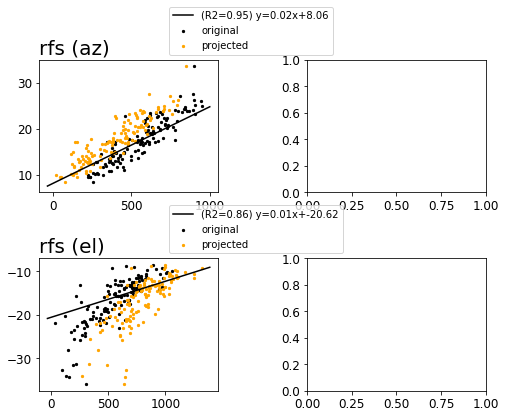

In [228]:
r2_thr=0.5
#rfname = 'rfs10'

fig, axn = pl.subplots(2,2, figsize=(8,8))
for ri, (rfname, expdf) in enumerate(rfdf.groupby(['experiment'])):
    for ci, cond in enumerate(['az', 'el']):
        ax = axn[ci, ri]
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'

        # Plot RF positions vs. cell locs
        cell_locs = expdf['%s_pos' % xname].values
        rf_locs = expdf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')

        proj_locs = expdf['%s_proj' % xname].values
        ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')

        #proj_locs2 = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
        #                         for ap, ml in edf[['ap_pos', 'ml_pos']].values]))

        # plot gradient line
        ret_ = ret_az if cond=='az' else ret_el
        fitv_ = fitv_az if cond=='az' else fitv_el
        regr_ = regr_az if cond=='az' else regr_el 
        slope = float(regr_.coef_)
        intercept = float(regr_.intercept_)
        r2_val = skmetrics.r2_score(ret_[~np.isnan(ret_)], fitv_)
        linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, slope, intercept, r2_val) 

        ls = ':' if r2_val < r2_thr else '-'
        label_prefix = 'R2=%.2f' % r2_val
        label = True
        ax = abline(slope, intercept, ax=ax, color='k',
                    label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title('%s (%s)' % (rfname, cond), loc='left', fontsize=20)

        ax.legend(bbox_to_anchor=(0.7, 1), loc='top')

pl.subplots_adjust(top=0.7, wspace=0.5, hspace=0.5)

# Get mask info

In [16]:
# Get ROIID and projection image
masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
nrois_total, d1, d2 = masks_soma.shape

# fig, ax = pl.subplots()
# roi_utils.plot_neuropil_masks(masks_soma, masks_np, zimg, ax=ax)
# ax.set_title('soma + neuropil masks')
# label_figure(fig, data_id)
# pl.savefig(os.path.join(curr_dst_dir, 'soma-v-neuropil-masks.png'))

... FOV size: (256, 256) (downsample factor=2)


# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

Nots: measured pixel size: (2.3, 1.9)
Want to dilate by ~9.52380952381


In [403]:
desired_radius_um = 10.0 #20.0
pixel_size = putils.get_pixel_size()
um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)
pixels2dilate = desired_radius_um/um_per_pixel
print("Measured pixel size: %s (~%.2fum/pix).\nPixel size with ds_factor %.2f = %i" % (str(pixel_size), um_per_pixel, ds_factor, pixels2dilate))



Measured pixel size: (2.3, 1.9) (~1.05um/pix).
Pixel size with ds_factor 2.00 = 9


In [404]:
check_masks = False

# Set kernel params
kernel_size = np.ceil(pixels2dilate) #+2 #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# Create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Kernel (%s), Dilation diameter (um): %.2f" % (str(kernel.shape), kernel_diam_um))

## Dilate all masks with kernel
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

if check_masks:
    fig, axn = pl.subplots(1, 2, figsize=(3,6))
    axn[0].imshow(kernel)

    rid = 33
    axn[1].imshow(dilated_masks[rid, :, :])
    axn[1].set_title("Kernel size: %.2f\n(final diam: %.2f um)" % (kernel_size, kernel_diam_um))
    x, y = np.where(dilated_masks[rid, :, :]>0)
    print "X/Y-min/max:", x.max()-x.min(), y.max()-y.min()


Kernel ((9, 9)), Dilation diameter (um): 9.45


# Rescale FOV image

((256, 256), (1177, 972))


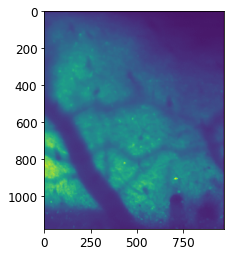

In [405]:
pixel_size = putils.get_pixel_size()
pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg.shape, zimg_r.shape)

pl.figure()
pl.imshow(zimg_r)

# Process raw traces

In [406]:
#### Load raw and process traces -- returns average trace for condition
temporal_ds = float(RETID['PARAMS']['average_frames'])

#### Load raw and process traces -- returns average trace for condition
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
temporal_ds = float(RETID['PARAMS']['average_frames'])
np_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='neuropil')
soma_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='raw')

... loading traces (neuropil)
... loading traces (raw)


# Do FFT analysis

Mag ratio: 0.01
[soma] 91 out of 311 cells pass mag-ratio thr (thr>=0.010, either)
[np] 75 out of 311 cells pass mag-ratio thr (thr>=0.100, either)


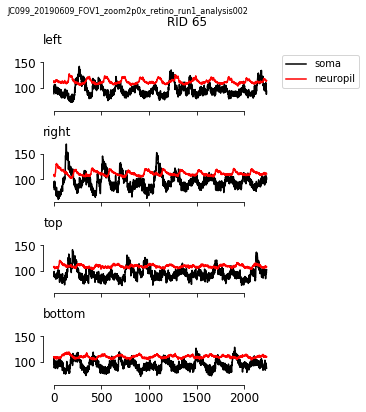

In [409]:
mag_thr=0.01 #if trace_type == 'neuropil' else 0.02
np_mag_thr = 0.1
pass_criterion='either'
plot_examples = True


print("Mag ratio: %.2f" % mag_thr)

#### Get FFT params
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate)) # Label frequency bins
sorted_freq_idxs = np.argsort(freqs)

#### Do FFT
fft_soma = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())

# Get magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))

# Get phases
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))

# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]

# Filter out bad cells
conds = [c for c in magratios_soma.columns if c!='blank']
if pass_criterion=='all':
    soma_rois = [i for i in magratios_soma.index if all(magratios_soma[conds].loc[i] >= mag_thr)]
    np_rois = [i for i in magratios_np.index if all(magratios_np[conds].loc[i] >= np_mag_thr)]
elif pass_criterion=='either':
    az_conds = [c for c in magratios_soma.columns if c in ['right', 'left']]
    el_conds = [c for c in magratios_soma.columns if c in ['top', 'bottom']]
    soma_rois = [i for i in magratios_soma.index \
                if (any(magratios_soma[az_conds].loc[i] >= mag_thr) \
                    and (any(magratios_soma[el_conds].loc[i] >= mag_thr))) ]
    np_rois = [i for i in magratios_np.index \
                if (any(magratios_np[az_conds].loc[i] >= mag_thr) \
                    and (any(magratios_np[el_conds].loc[i] >= np_mag_thr))) ]
elif pass_criterion == 'any':
    soma_rois = [i for i in magratios_soma.index if any(magratios_soma[conds].loc[i] >= mag_thr) ]
    np_rois = [i for i in magratios_np.index if any(magratios_np[conds].loc[i] >= np_mag_thr)]
else:
    soma_rois = magratios_soma.index.tolist()
    np_rois = magratios_np.index.tolist()

nrois_total = len(mean_magratio_values_soma)
print("[soma] %i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(soma_rois), nrois_total, mag_thr, pass_criterion))
print("[np] %i out of %i cells pass mag-ratio thr (thr>=%.3f, %s)" % (len(np_rois), nrois_total, np_mag_thr, pass_criterion))

sorted_by_mag = [r for r in sorted_rois_soma if r in roi_list]

# Look at example cell
if plot_examples:
    ret_utils.plot_some_example_traces(soma_traces, np_traces, plot_rois=sorted_rois_soma[0:3],
                         dst_dir=curr_dst_dir, data_id=data_id)
    

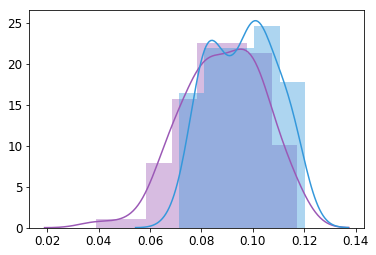

In [410]:
pl.figure()
sns.distplot(magratios_np.loc[soma_rois].mean(axis=1))
sns.distplot(magratios_np.loc[np_rois].mean(axis=1))

# Assign phase to neuropil

In [411]:
azim_phase_np, elev_phase_np, azim_np, elev_np = get_phase_masks(dilated_masks, phases_np, 
                                                            average_overlap=average_overlap, 
                                                            roi_list=None, use_cont=use_cont,
                                                            mask_thr=mask_thr, return_absolute=True)


In [412]:
# soma_mag_means = magratios_soma.mean(axis=1)
np_mag_means_from_soma = magratios_np.loc[soma_rois].mean(axis=1)
np_mag_means_from_np = magratios_np.loc[np_rois].mean(axis=1)

np_mag_means = magratios_np.mean(axis=1) # magratios_np.loc[np_rois].mean(axis=1)

In [413]:
np_mag_thr=0.1
pass_np_rlist_from_soma = np_mag_means_from_soma[np_mag_means_from_soma>=np_mag_thr].index.tolist()
pass_np_rlist_from_np = np_mag_means_from_np[np_mag_means_from_np>=np_mag_thr].index.tolist()
pass_np_rlist = np_mag_means[np_mag_means>=np_mag_thr].index.tolist()

print("NP filtered: %i, Soma filtered: %i, NP mean: %i" 
      % (len(pass_np_rlist_from_np), len(pass_np_rlist_from_soma), len(pass_np_rlist)))
fail_np_rlist_from_soma = [r for r in roi_list if r not in pass_np_rlist_from_soma]
fail_np_rlist = [r for r in roi_list if r not in pass_np_rlist]

NP filtered: 33, Soma filtered: 24, NP mean: 51


In [415]:
animalid, session

('JC099', '20190609')

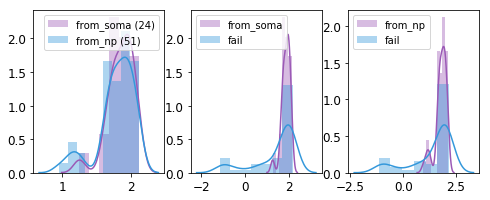

In [416]:
fig, axn = pl.subplots(1,3, figsize=(8,3))
ax = axn[0]
sns.distplot(azim_np[pass_np_rlist_from_soma].values, label='from_soma (%i)' % len(pass_np_rlist_from_soma), ax=ax)
sns.distplot(azim_np[pass_np_rlist].values, label='from_np (%i)' % len(pass_np_rlist), ax=ax)
ax.legend()

ax = axn[1]
sns.distplot(azim_np[pass_np_rlist_from_soma].values, label='from_soma', ax=ax)
sns.distplot(azim_np[fail_np_rlist_from_soma].values, label='fail', ax=ax)
ax.legend()


ax = axn[2]
sns.distplot(azim_np[pass_np_rlist].values, label='from_np', ax=ax)
sns.distplot(azim_np[fail_np_rlist].values, label='fail', ax=ax)
ax.legend()


In [417]:
import copy

In [418]:
print(len(pass_np_rlist))

51


In [420]:
roi_list = copy.copy(pass_np_rlist)
print(len(roi_list))

51


In [421]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

# Set bounds for averaging
vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi

# Assign phase value to dilated masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

# Mask images for plotting
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)


# Smooth

In [422]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)

if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    
azim_smoothed = fill_and_smooth_nans(azim_smoothed)
elev_smoothed = fill_and_smooth_nans(elev_smoothed)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()

azim_soma_r = coreg.transform_2p_fov(azim_phase_mask_np, pixel_size, normalize=False)
elev_soma_r = coreg.transform_2p_fov(elev_phase_mask_soma, pixel_size, normalize=False)

(0.0, 2.3776783896661216)


(u'/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_733e38/retino-structure', 'soma-v-neuropil_dilate-center-10_spatial-smooth-7_circ_magthr-0.010-either')


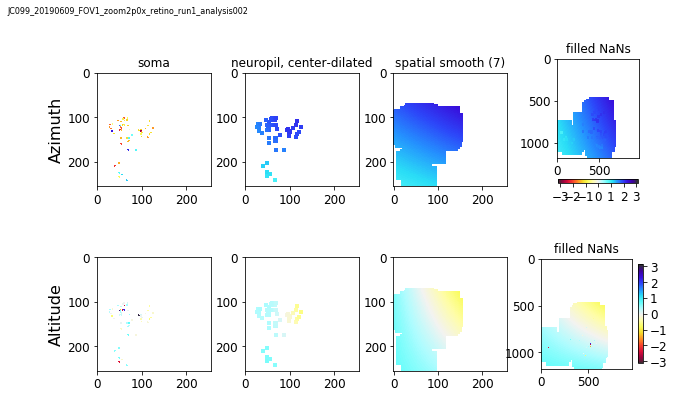

In [423]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.set_title('neuropil, center-dilated')
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)
ax.imshow(azim_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im1, ax=ax, orientation='vertical', shrink=0.7)
ax.imshow(elev_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)

pl.subplots_adjust(wspace=0.3, hspace=0.3)
putils.label_figure(fig, data_id)

figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i_circ_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

#### Plot smoothed azimuth neuropil

Text(0.5,1,u'Altitude')

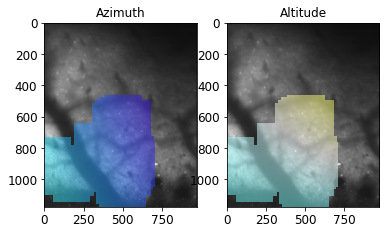

In [424]:
cmap = 'nipy_spectral' # cmap_phase
overlay = True
overlay_str = '_overlay' if overlay else ''
alpha = 0.5 if overlay else 1.0

fig, axn = pl.subplots(1,2)
ax = axn[0]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Azimuth')

ax = axn[1]
if overlay:
    ax.imshow(zimg_r, cmap='gray')
ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
ax.set_title('Altitude')

#figname = 'overlay_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Calculate image gradient

In [425]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [426]:
plot_degrees = True

vmin=-np.pi
vmax=np.pi
img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)


# Calculate gradients
if plot_degrees:
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)
else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    # vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(u'/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_733e38/retino-structure', 'gradients_dilate-center-10_spatial-smooth-7_degrees_circ_magthr-0.010-either')


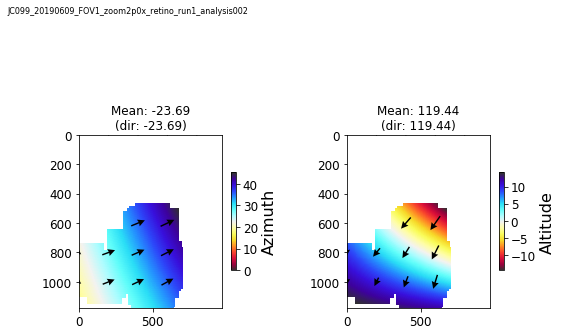

In [429]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i_%s_circ_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)

#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [382]:
len(roi_list)

48

## Compute unit vector and project

In [383]:
avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: 30.18 deg
[AZ]avg dir: 179.47 deg
(array([-0.99995744,  0.00922633]), array([ 0.8644171 ,  0.50277538]))


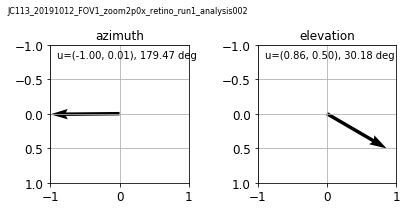

In [384]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'gradients_unitvec_dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


# Project coordinates onto "prevailing" retino dir

In [385]:
gimg_az = grad_az['image'].copy()
gimg_el = grad_el['image'].copy()

d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)


# Projected pixel positoins
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

# Retino values
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


(1177, 972)
(array([-0.99995744,  0.00922633]), array([ 0.8644171 ,  0.50277538]))


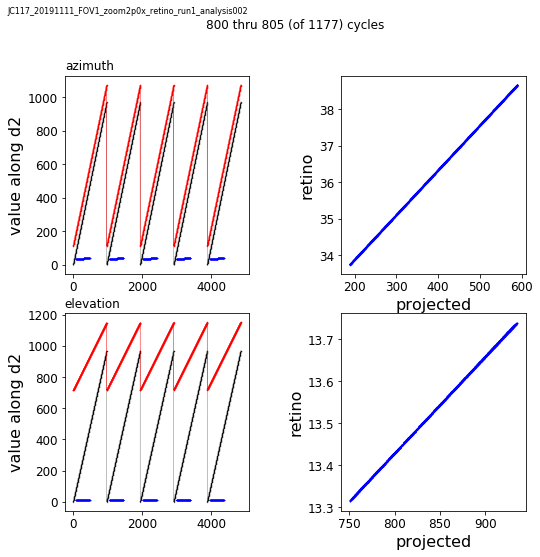

In [358]:
fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()

ncyc=5

startcyc=800
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.set_title('azimuth', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)
ax.set_ylabel('value along d2')

ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.set_title('elevation', loc='left')
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


## Fit linear

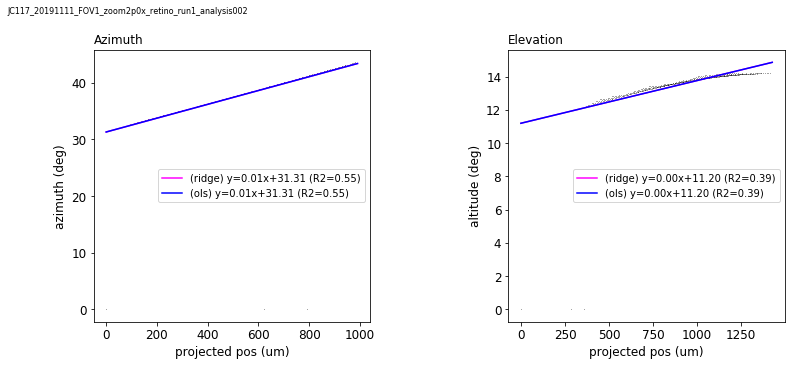

In [359]:
regr_model = 'ridge'
regr_line_color = 'magenta'
regr_model2 = 'ols' 

fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

fitv_az2, regr_az2 = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model2)
fitv_el2, regr_el2 = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model2)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=800
ax=axn[0]
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
r2_az = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color=regr_line_color, label=linfit_str)

r2_az2 = skmetrics.r2_score(ret_az[~np.isnan(ret_az)], fitv_az2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_az2.coef_), float(regr_az2.intercept_), r2_az2) 
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Azimuth', loc='left')
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model, float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color=regr_line_color, label=linfit_str)

r2_el2 = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el2)
linfit_str2 = '(%s) y=%.2fx+%.2f (R2=%.2f)' % (regr_model2, float(regr_el2.coef_), float(regr_el2.intercept_), r2_el2) 
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el2, color='b', label=linfit_str2)
ax.legend()

ax.set_title('Elevation', loc='left')
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
#figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.3f-%s_test' % (kernel_size, smooth_fwhm, plot_str, mag_thr, pass_criterion)
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Example FOV -------------------------------------------------------------------------------

In [191]:
animalid = 'JC084' #'JC085'
session = '20190522' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'


# Load data

In [194]:
# Load data metainfo
# run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
# RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
# analysis_dir = RETID['DST']
# retinoid = RETID['analysis_id']
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
curr_dst_dir = os.path.join(run_dir, 'retino_analsysis', 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)

FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC084_20190522_FOV1_zoom2p0x_retino_run1_analysis001
Saving output to:
 /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analsysis/retino-structure


# ----------------------------------------------------------------------------------------------------
# Aggregate projection results
This is output of classifications/aggregate_gradient_estimates()


In [13]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
    return

## Load data

In [28]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

filter_by='drop_repeats'

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)

data_id = 'retinobar|%s|%s|%s' % (state, fov_type, fit_desc)
print(data_id)


pass_criterion='npmean'
mag_thr = 0.1 if pass_criterion=='npmean' else 0.01

magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)

retinobar|awake|zoom2p0x|fit-2dgaus_dff-no-cutoff
npmean_thr-0.100


In [18]:
# Get datasets that have BOTH rfs and retinogradient measured
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
bothdata = pd.concat([g for s, g in sdata.groupby(['animalid', 'session', 'fov']) \
                        if ('retino' in sdata['experiment'].values) and \
                        ('rfs' in sdata['experiment'].values or 'rfs10' in sdata['experiment'].values)])
bothdata['datakey'] = ['_'.join([session, animalid, 'fov%i' % fovnum]) \
                         for (session, animalid, fovnum) in bothdata[['session', 'animalid', 'fovnum']].values]

common_datakeys = bothdata['datakey'].unique()

In [19]:
bothdata[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()

,animalid,session,fov
visual_area,,,
Li,26,26,26
Lm,22,22,22
V1,18,18,18


In [20]:
retdata = bothdata[bothdata['experiment']=='retino'].copy()
print("N retinobar experiment fovs:")
print(retdata.groupby(['visual_area']).count())

N retinobar experiment fovs:
             animalid  experiment  fov  session  fovnum  datakey
visual_area                                                     
Li                 23          23   23       23      23       23
Lm                 19          19   19       19      19       19
V1                 15          15   15       15      15       15


In [29]:
print("Threshold info: %s" % magthr_str)
meta_list = get_retino_metadata(experiment='retino', traceid=traceid)

proj_fit_paths=[]; errors=[];
for (animalid, session, fov, retinorun, _) in meta_list:
    # Load data metainfo
    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    
    datakey = '_'.join([session, animalid, fov, retinorun])
    try:
        fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
                                                'retino_analysis', '%s*' % retinoid, 
                                                'retino-structure', 'projections_%s.pkl' % magthr_str)) # 'projection_results.pkl'))
        assert len(fpaths)==1, "[%s] %i paths found" % (datakey, len(fpaths))
    except Exception as e:
        errors.append(datakey)
        continue
    proj_fit_paths.append((animalid, session, fov, retinorun, retinoid, fpaths[0]))
print("%i of %i paths found" % (len(proj_fit_paths), len(meta_list)))

Threshold info: npmean_thr-0.100
skipping, no retino (JC076, 20190502, FOV1_zoom2p0x)
skipping, no retino (JC091, 20191007, FOV1_zoom2p0x)
skipping, no retino (JC092, 20190527, FOV2_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV1_zoom2p0x)
skipping, no retino (JC097, 20190615, FOV3_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV1_zoom2p0x)
skipping, no retino (JC110, 20191004, FOV4_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV3_zoom2p0x)
skipping, no retino (JC120, 20191106, FOV4_zoom2p0x)
24 of 60 paths found


In [30]:
errors

['20190420_JC076_FOV1_zoom2p0x_retino_run1',
 '20190422_JC076_FOV1_zoom2p0x_retino_run1',
 '20190423_JC076_FOV1_zoom2p0x_retino_run1',
 '20190501_JC076_FOV1_zoom2p0x_retino_run1',
 '20190430_JC078_FOV1_zoom2p0x_retino_run1',
 '20190504_JC078_FOV1_zoom2p0x_retino_run1',
 '20190509_JC078_FOV1_zoom2p0x_retino_run1',
 '20190513_JC078_FOV1_zoom2p0x_retino_run1',
 '20190602_JC080_FOV1_zoom2p0x_retino_run1',
 '20190507_JC083_FOV1_zoom2p0x_retino_run1',
 '20190507_JC083_FOV1_zoom2p0x_retino_run2',
 '20190508_JC083_FOV1_zoom2p0x_retino_run2',
 '20190510_JC083_FOV1_zoom2p0x_retino_run1',
 '20190511_JC083_FOV1_zoom2p0x_retino_run1',
 '20190522_JC084_FOV1_zoom2p0x_retino_run1',
 '20190525_JC084_FOV1_zoom2p0x_retino_run1',
 '20190525_JC084_FOV1_zoom2p0x_retino_run2',
 '20190602_JC091_FOV1_zoom2p0x_retino_run1',
 '20190614_JC091_FOV1_zoom2p0x_retino_run1',
 '20191008_JC091_FOV1_zoom2p0x_retino_run1',
 '20190527_JC092_FOV3_zoom2p0x_retino_run1',
 '20190528_JC092_FOV1_zoom2p0x_retino_run1',
 '20191004

In [26]:
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run2'

fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun,
                                        'retino_analysis', '%s*' % retinoid, 
                                        'retino-structure', 'projections_%s.pkl' % magthr_str)) # 'projection_results.pkl'))
assert len(fpaths)==1, "[%s] %i paths found" % (datakey, len(fpaths))

AssertionError: [20191111_JC120_FOV1_zoom2p0x_retino_run1] 0 paths found

In [31]:
magthr_str

'npmean_thr-0.100'

In [33]:
# Create dir to copy gradient images to, for visual inspection
copy_images = True

dst = os.path.join(aggr_retino_dir, 'gradient_analysis', 'individual_session_inputs')
if not os.path.exists(dst):
    os.makedirs(dst)
    
if copy_images:
    delete_files(dst)

In [47]:
proj_fit_paths

[('JC076',
  '20190420',
  'FOV1_zoom2p0x',
  'retino_run1',
  u'analysis002',
  u'/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_7d07d1/retino-structure/projections.pkl'),
 ('JC076',
  '20190422',
  'FOV1_zoom2p0x',
  'retino_run1',
  u'analysis002',
  u'/n/coxfs01/2p-data/JC076/20190422/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_499a27/retino-structure/projections.pkl'),
 ('JC076',
  '20190423',
  'FOV1_zoom2p0x',
  'retino_run1',
  u'analysis002',
  u'/n/coxfs01/2p-data/JC076/20190423/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_e6486c/retino-structure/projections.pkl'),
 ('JC076',
  '20190501',
  'FOV1_zoom2p0x',
  'retino_run1',
  u'analysis002',
  u'/n/coxfs01/2p-data/JC076/20190501/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_fbab9d/retino-structure/projections.pkl'),
 ('JC078',
  '20190430',
  'FOV1_zoom2p0x',
  'retino_run1',
  u'analysis002',
  u'/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0x/retino_run1/r

In [34]:
d_list=[]
for di, (animalid, session, fov, retinorun, retinoid, fpath) in enumerate(proj_fit_paths):
    if di % 20 == 0 or di==(len(proj_fit_paths)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(proj_fit_paths)))
        
    fovnum = int(fov.split('_')[0][3:])
    datakey = '_'.join([session, animalid, 'fov%i' % fovnum])
    with open(fpath, 'rb') as f:
        res = pkl.load(f)
    
    tmpd = res['regr_df'].copy()
    tmpd['animalid'] = [animalid for _ in np.arange(0, tmpd.shape[0])]
    tmpd['session'] = [session for _ in np.arange(0, tmpd.shape[0])]
    tmpd['fov'] = [fov for _ in np.arange(0, tmpd.shape[0])]
    tmpd['retinorun'] = [retinorun for _ in np.arange(0, tmpd.shape[0])]
    tmpd['retinoid'] = [retinoid for _ in np.arange(0, tmpd.shape[0])]
    tmpd['datakey'] = [datakey for _ in np.arange(0, tmpd.shape[0])]
    tmpd['fpath'] = [fpath for _ in np.arange(0, tmpd.shape[0])]
    visual_area = retdata[(retdata['animalid']==animalid) 
                          & (retdata['session']==session) 
                          & (retdata['fov']==fov)]['visual_area'].values
    assert len(visual_area)==1, "[%s] Unknown visual area: %s" % (datakey, str(visual_area))
    tmpd['visual_area'] = [visual_area[0] for _ in np.arange(0, tmpd.shape[0])]
    d_list.append(tmpd)

    if copy_images:
        src = os.path.split(fpath)[0]
        fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
        for fimpath in fimpaths:
            fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
            shutil.copyfile(fimpath, os.path.join(dst, '%s_%s_%s_%s%s' % (visual_area[0], datakey, retinorun, fname, fext)))
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)

projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

print(projection_df.shape)
projection_df.head()

1 of 24 gradient result files loaded.
21 of 24 gradient result files loaded.
24 of 24 gradient result files loaded.
(48, 17)


,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef,cortical_mag
0,0.958217,3.235140,0.065643,az,65.812248,0.0,0.978886,JC080,20190506,FOV1_zoom2p0x,retino_run1,analysis002,20190506_JC080_fov1,/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0...,Lm,0.065643,15.234003
1,0.940481,1.436612,0.022935,el,-0.020323,0.0,0.969784,JC080,20190506,FOV1_zoom2p0x,retino_run1,analysis002,20190506_JC080_fov1,/n/coxfs01/2p-data/JC080/20190506/FOV1_zoom2p0...,Lm,0.022935,43.602017
2,0.988782,1.202747,0.058868,az,33.777135,0.0,0.994375,JC080,20190602,FOV2_zoom2p0x,retino_run1,analysis002,20190602_JC080_fov2,/n/coxfs01/2p-data/JC080/20190602/FOV2_zoom2p0...,Lm,0.058868,16.987149
3,0.897165,1.802253,0.025520,el,-12.128282,0.0,0.947188,JC080,20190602,FOV2_zoom2p0x,retino_run1,analysis002,20190602_JC080_fov2,/n/coxfs01/2p-data/JC080/20190602/FOV2_zoom2p0...,Lm,0.025520,39.184728
4,0.766945,5.722985,0.039656,az,45.155327,0.0,0.875754,JC080,20190603,FOV1_zoom2p0x,retino_run1,analysis002,20190603_JC080_fov1,/n/coxfs01/2p-data/JC080/20190603/FOV1_zoom2p0...,Lm,0.039656,25.216967


In [37]:
projection_df.groupby(['visual_area', 'datakey']).count()

R2  RMSE  coefficient  cond  intercept  \
visual_area datakey                                                       
Li          20190522_JC089_fov1   2     2            2     2          2   
            20190605_JC090_fov1   4     4            4     4          4   
            20190606_JC091_fov1   2     2            2     2          2   
            20190607_JC091_fov1   2     2            2     2          2   
            20190609_JC099_fov1   2     2            2     2          2   
            20190612_JC099_fov1   2     2            2     2          2   
            20190617_JC099_fov1   2     2            2     2          2   
Lm          20190506_JC080_fov1   2     2            2     2          2   
            20190508_JC083_fov1   2     2            2     2          2   
            20190512_JC083_fov1   2     2            2     2          2   
            20190517_JC083_fov1   2     2            2     2          2   
            20190602_JC080_fov2   2     2            2     2          2   
            20190603_JC080_fov1   2     2            2     2          2   
            20190618_JC097_fov1   2     2            2     2          2   
            20190627_JC091_fov1   2     2            2     2          2   
            20191104_JC117_fov2   2     2            2     2          2   
V1          20190522_JC084_fov1   2     2            2     2          2   
            20190613_JC097_fov1   2     2            2     2          2   
            20190615_JC097_fov2   2     2            2     2          2   
            20190616_JC097_fov1   2     2            2     2          2   
            20190617_JC097_fov1   2     2            2     2          2   
            20190622_JC085_fov1   2     2            2     2          2   
            20191111_JC117_fov1   2     2            2     2          2   

                                 pearson_p  pearson_r  animalid  session  fov  \
visual_area datakey                                                             
Li          20190522_JC089_fov1          2          2         2        2    2   
            20190605_JC090_fov1          4          4         4        4    4   
            20190606_JC091_fov1          2          2         2        2    2   
            20190607_JC091_fov1          2          2         2        2    2   
            20190609_JC099_fov1          2          2         2        2    2   
            20190612_JC099_fov1          2          2         2        2    2   
            20190617_JC099_fov1          2          2         2        2    2   
Lm          20190506_JC080_fov1          2          2         2        2    2   
            20190508_JC083_fov1          2          2         2        2    2   
            20190512_JC083_fov1          2          2         2        2    2   
            20190517_JC083_fov1          2          2         2        2    2   
            20190602_JC080_fov2          2          2         2        2    2   
            20190603_JC080_fov1          2          2         2        2    2   
            20190618_JC097_fov1          2          2         2        2    2   
            20190627_JC091_fov1          2          2         2        2    2   
            20191104_JC117_fov2          2          2         2        2    2   
V1          20190522_JC084_fov1          2          2         2        2    2   
            20190613_JC097_fov1          2          2         2        2    2   
            20190615_JC097_fov2          2          2         2        2    2   
            20190616_JC097_fov1          2          2         2        2    2   
            20190617_JC097_fov1          2          2         2        2    2   
            20190622_JC085_fov1          2          2         2        2    2   
            20191111_JC117_fov1          2          2         2        2    2   

                                 retinorun  retinoid  fpath  abs_coef  \
visual_area datakey                                       

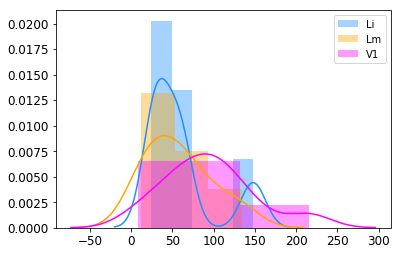

In [49]:
r2_thr=0.5
fig, ax = pl.subplots()
for visual_area, g in projection_df[projection_df['R2']>r2_thr].groupby(['visual_area']):
    sns.distplot(g['cortical_mag'].values, ax=ax, color=area_colors[visual_area], label=visual_area)
ax.legend()

In [62]:
bad = projection_df[projection_df['cortical_mag']>5000]

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef,cortical_mag
0,0.000244,3.919709,-0.000173,az,32.308715,4.735684e-09,-0.015619,JC113,20191012,FOV1_zoom2p0x,retino_run1,analysis002,20191012_JC113_fov1,/n/coxfs01/2p-data/JC113/20191012/FOV1_zoom2p0...,Li,0.000173,5768.561112


In [67]:
projection_df = projection_df[projection_df['cortical_mag']<5000]

In [442]:
# Load 1 fov to test sth
animalid='JC110'
session = '20191006'
fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
print(fpath)
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)
p_df = res['regr_df'].copy()
print(p_df)

# gradient info
grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_5ae341/retino-structure/projection_results.pkl
(array([[ 0.02216148]]), array([ 19.95735156]))
         R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r
0  0.928207  1.648383     0.022161   az  19.957352        0.0   0.963435
1  0.969433  0.526419     0.010254   el -12.249892        0.0   0.984598


['el', 'az']

# Filter FOVs with bad gradient fits 
(Set some R2 threshold)
"Bad" fits suggests that the retino gradient was messed up or points were all over the place?

In [50]:
r2_thr=0.5
fit_str = 'R2-%.2f' % r2_thr

# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in projection_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) and (g[g['cond']=='el']['R2'].values > r2_thr))])
projdf['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in projdf[['datakey', 'retinorun']].values]
print(projection_df.shape, projdf.shape)


((48, 17), (22, 18))


# Cortical magnification

In [51]:
def plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el', 
                          compare_var='cond', area_colors=None):

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    ax = rfutils.pairwise_compare_single_metric(plotdf, curr_metric=curr_metric, ax=ax,
                                                c1=c1, c2=c2, compare_var=compare_var)
    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10)
    # Set x labels
    rfutils.set_split_xlabels(ax, a_label=c1, b_label=c2)

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(plotdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.6,1.2), fontsize=8)

    return fig


In [52]:
def plot_axis_distributions(projdf, currmetric='abs_coef', hue='cond',
                            currcols=['windows blue', 'amber'], area_colors=None):

    bi_palette = sns.xkcd_palette(currcols)

    fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    sns.stripplot(x='visual_area', y=currmetric, hue=hue, data=projdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                 order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", currmetric, data=projdf,
               hue=hue, order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)

    #ax.set_ylim([0, 0.12])
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    label_figure(fig, data_id)
    pl.legend(bbox_to_anchor=((1.2, 1)))
    projdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10)

    # Set x labels
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

    # Get counts of samples for legend
    legend_elements = aggr.get_counts_for_legend(projdf, area_colors=area_colors, markersize=10, marker='_')
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.6,1.2), fontsize=8)

    return fig

### Cortical mag, pairwise

V1: (t-stat:2.91, p=0.06)
Lm: (t-stat:3.23, p=0.03)
Li: (t-stat:-1.34, p=0.41)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'rate_of_retino_change_paired_R2-0.50_npmean_thr-0.100')


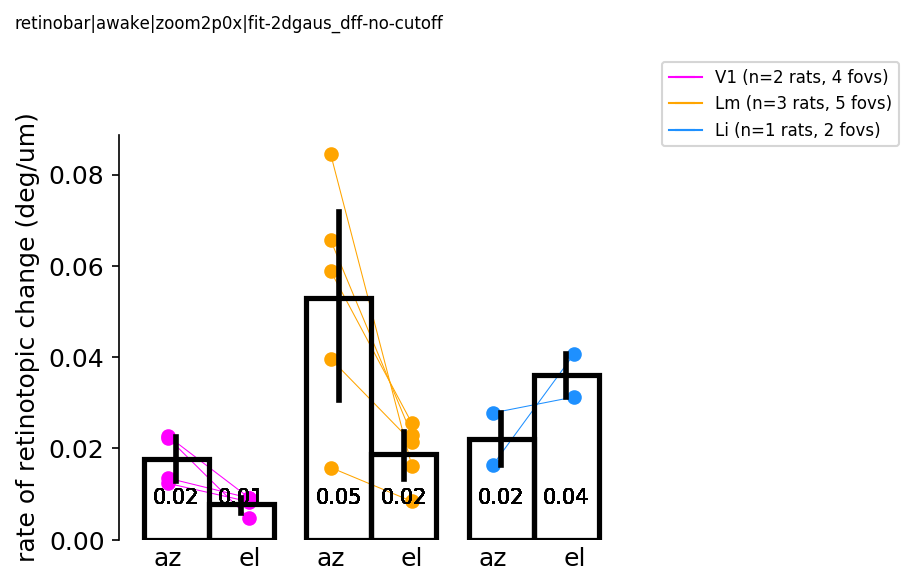

In [56]:

plotdf = projdf.copy()
fig = plot_pairwise_by_axis(plotdf, curr_metric='abs_coef', c1='az', c2='el',
                           area_colors=area_colors)
pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)
pl.ylabel('rate of retinotopic change (deg/um)', fontsize=12)

#ax.set_ylim([0, 0.1])
figname = 'rate_of_retino_change_paired_%s_%s' % (fit_str, magthr_str)
#pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))

print(aggr_retino_dir, figname)

In [57]:
plotdf['cortical_mag'].max()

215.01446516749095

## Plot inverse (cortical mag)

V1: (t-stat:-2.46, p=0.09)
Lm: (t-stat:-4.90, p=0.01)
Li: (t-stat:1.25, p=0.43)
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'cortical_mag_paired_R2-0.50_npmean_thr-0.100')


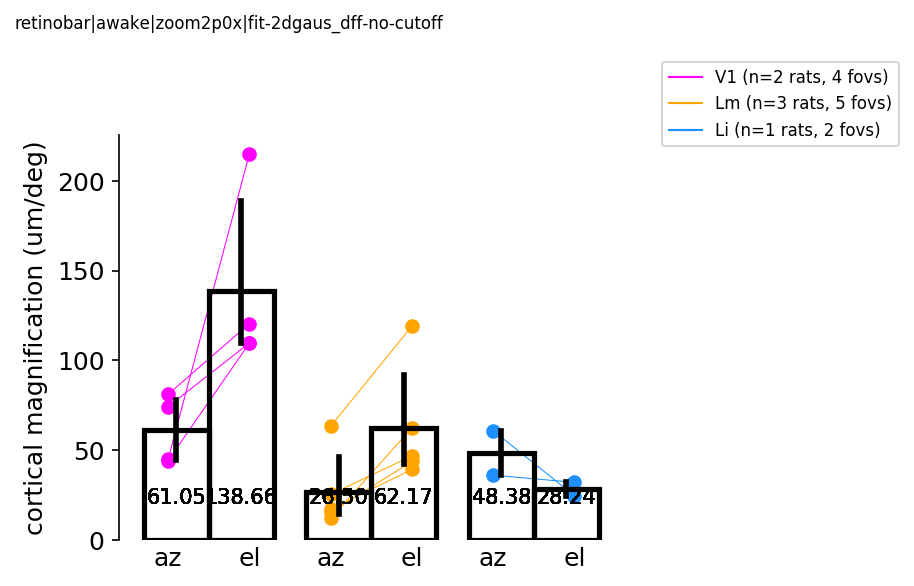

In [58]:
metric = 'cortical_mag'
#plotdf = projdf.copy()
fig = plot_pairwise_by_axis(plotdf, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors)
pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)
pl.ylabel('cortical magnification (um/deg)', fontsize=12)

#ax.set_ylim([0, 0.1])
figname = '%s_paired_%s_%s' % (metric, fit_str, magthr_str)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))

print(aggr_retino_dir, figname)

In [85]:
projdf[(projdf['cortical_mag']>150) & (projdf['R2']>r2_thr)]


,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef,cortical_mag,retinokey
9,0.596685,1.038210,0.006552,el,11.053185,0.0,0.772454,JC078,20190430,FOV1_zoom2p0x,retino_run1,analysis002,20190430_JC078_fov1,/n/coxfs01/2p-data/JC078/20190430/FOV1_zoom2p0...,Lm,0.006552,152.614661,20190430_JC078_fov1_retino_run1
95,0.952008,0.383429,0.004827,el,-2.226262,0.0,0.975709,JC113,20191012,FOV1_zoom2p0x,retino_run1,analysis002,20191012_JC113_fov1,/n/coxfs01/2p-data/JC113/20191012/FOV1_zoom2p0...,Li,0.004827,207.165590,20191012_JC113_fov1_retino_run1
104,0.544443,0.679668,0.005836,az,7.202490,0.0,0.737864,JC117,20191105,FOV1_zoom2p0x,retino_run1,analysis002,20191105_JC117_fov1,/n/coxfs01/2p-data/JC117/20191105/FOV1_zoom2p0...,Li,0.005836,171.340769,20191105_JC117_fov1_retino_run1
107,0.841161,0.526038,0.005825,el,9.342979,0.0,0.917148,JC117,20191111,FOV1_zoom2p0x,retino_run1,analysis002,20191111_JC117_fov1,/n/coxfs01/2p-data/JC117/20191111/FOV1_zoom2p0...,V1,0.005825,171.671933,20191111_JC117_fov1_retino_run1


### Cortical mag, either axis passes

In [59]:
r2_thr=0.5
fit_str = 'R2-%.2f' % r2_thr

# Select FOVs with BOTH azimuth and elevation passed
projdf = pd.concat([g for (datakey, retinorun), g in projection_df.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])
projdf['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun in projdf[['datakey', 'retinorun']].values]
print(projection_df.shape, projdf.shape)

((48, 17), (38, 18))


('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'rate_of_retino_change_R2-0.50_npmean_thr-0.100')


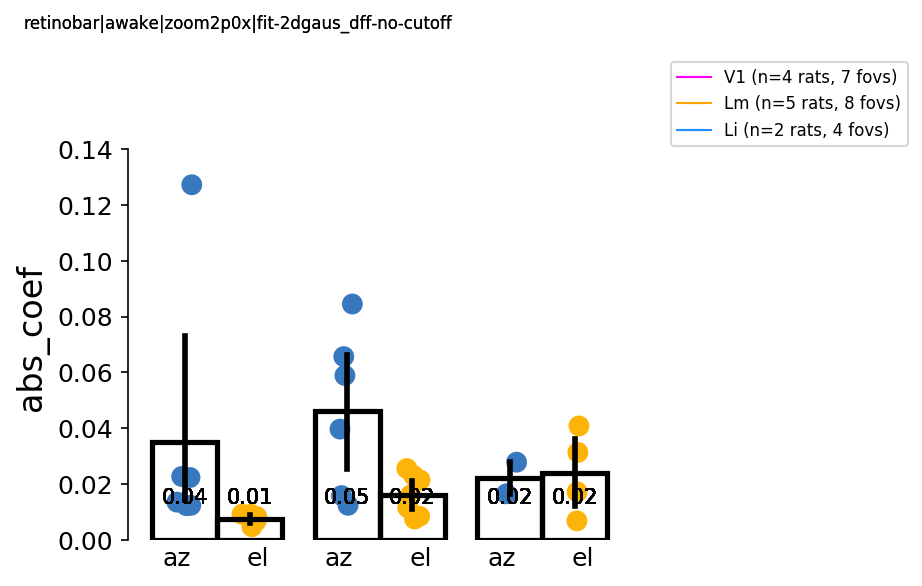

In [60]:
currmetric='abs_coef'
hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(projdf[projdf['R2']>r2_thr], currmetric=currmetric, hue=hue,
                            currcols=currcols, area_colors=area_colors)
pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)

figname = 'rate_of_retino_change_%s_%s' % (fit_str, magthr_str)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))

print(aggr_retino_dir, figname)

In [61]:
projdf[projdf['cortical_mag']>5000]


,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef,cortical_mag,retinokey


('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'cortical_mag_R2-0.50_npmean_thr-0.100')


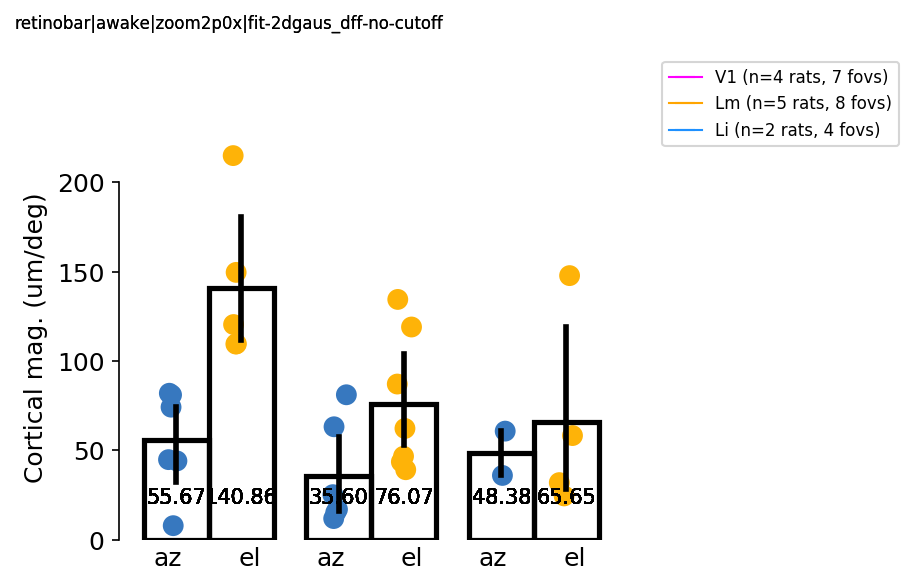

In [62]:
currmetric='cortical_mag'
hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(projdf[projdf['R2']>r2_thr], currmetric=currmetric, hue=hue,
                            currcols=currcols, area_colors=area_colors)
pl.ylabel('Cortical mag. (um/deg)', fontsize=12)

pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)

figname = '%s_%s_%s' % (currmetric, fit_str, magthr_str)
#pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))

print(aggr_retino_dir, figname)

# Scatter

In [149]:
from pipeline.python.rois.utils import load_roi_coords

In [150]:
def get_rf_dataframe(filter_by=None, fit_thr=0.5, traceid='traces001',
                    fit_desc='fit-2dgaus_dff-no-cutoff', fov_type='zoom2p0x',
                    state='awake', stimulus='rfs', verbose=False):
    
    #### Get non-repeated FOV datasets
    r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                      traceid=traceid, fit_desc=fit_desc,
                                                      reliable_only=reliable_only, verbose=verbose,
                                                      fov_type=fov_type, state=state, stimulus=stimulus)

    #### Split fx, fy for theta comp
    r_df['fx'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.cos(r_df['theta']))
    r_df['fy'] = abs(r_df[['std_x', 'std_y']].max(axis=1) * np.sin(r_df['theta']))
    r_df['ratio_xy'] = r_df['std_x']/r_df['std_y']

    # Convert thetas to [-90, 90]
    thetas = [(t % np.pi) - np.pi if ((np.pi/2.)<t<(np.pi) or (((3./2)*np.pi)<t<2*np.pi)) \
              else (t % np.pi) for t in r_df['theta'].values]
    r_df['theta_c'] = thetas

    return r_df

In [151]:
def abline(slope, intercept, ax=None, color='purple', ls='-',
           label=True, label_prefix=''):
    """Plot a line from slope and intercept"""
    if ax is None:
        fig, ax = pl.subplots()
    #axes = plt.gca()
    #x_vals = np.array(axes.get_xlim())
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    label_str = '(%s) y=%.2fx+%.2f' % (label_prefix, slope, intercept) if label else None
    ax.plot(x_vals, y_vals, '--', label=label_str, color=color, ls=ls)
    ax.legend()
    return ax

### Select RF dataset filters

In [155]:
filter_by = 'drop_repeats'

scale_sigma = False
reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

#filter_str = '%s_%s_retinog%s' % (filter_by, reliable_str, fit_str)
#print(filter_str)
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

### Get cell positions (and RF info)

In [156]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(aggr_rf_dir):
    os.makedirs(aggr_rf_dir)
print("... saving output to base dir:\n%s" % aggr_rf_dir)


NameError: name 'fit_desc' is not defined

In [157]:
#df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s_%s.pkl' % (filter_by, reliable_str, rfname))
df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s_r_df.pkl' % (filter_by, reliable_str))
print(df_fpath)

NameError: name 'aggr_rf_dir' is not defined

In [69]:
get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            r_df = pkl.load(f)
    except Exception as e:
        get_positions = True
print(get_positions)

Loading existing RF coord conversions...
False


In [70]:
if get_positions:
    # Get RF fit info first
    r_df = get_rf_dataframe(filter_by=filter_by, reliable_only=reliable_only,
                     fit_thr=fit_thr, traceid=traceid, fit_desc=fit_desc,
                    verbose=False, fov_type=fov_type, state=state, stimulus='rfs')
    
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        r_df[p] = ''
    
    # Add fov coord info and save
    p_list=[]
    for (animalid, session, fovnum, exp), g in r_df.groupby(['animalid', 'session', 'fovnum', 'experiment']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            r_df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(r_df, f, protocol=pkl.HIGHEST_PROTOCOL)

In [71]:
# no_retino=[]
# for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
#     if (projdf[projdf['datakey']==datakey].shape[0])==0:
#         no_retino.append((visual_area, datakey))
# for r in no_retino:
#     print r
    

#### Test single FOV with above fits, after loading RF stuff

In [331]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )


fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], 
                                          return_regr=True, model=regr_model)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], 
                                          return_regr=True, model=regr_model)

In [585]:
# Load 1 fov to test sth
animalid='JC085'
session = '20190622'
fpath = [p for p in proj_fit_paths if p[0]==animalid and p[1]==session and p[3]=='retino_run1'][0][5]
print(fpath)
with open(fpath, 'rb') as f:
    res = pkl.load(f)
print(res['regr_az'].coef_, res['regr_az'].intercept_)
p_df = res['regr_df'].copy()
print(p_df)

# gradient info
grad_fpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(grad_fpath, 'rb') as f:
    gresults = pkl.load(f)
gresults.keys()


/n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_f48037/retino-structure/projection_results.pkl
(array([[ 0.00689552]]), array([ 28.9482809]))
         R2      RMSE  coefficient cond  intercept  pearson_p  pearson_r
0  0.474316  2.214660     0.006896   az  28.948281        0.0   0.688706
1  0.942234  0.691157     0.009458   el -14.141244        0.0   0.970687


['el', 'az']

Text(0.5,0.98,u'Lm')

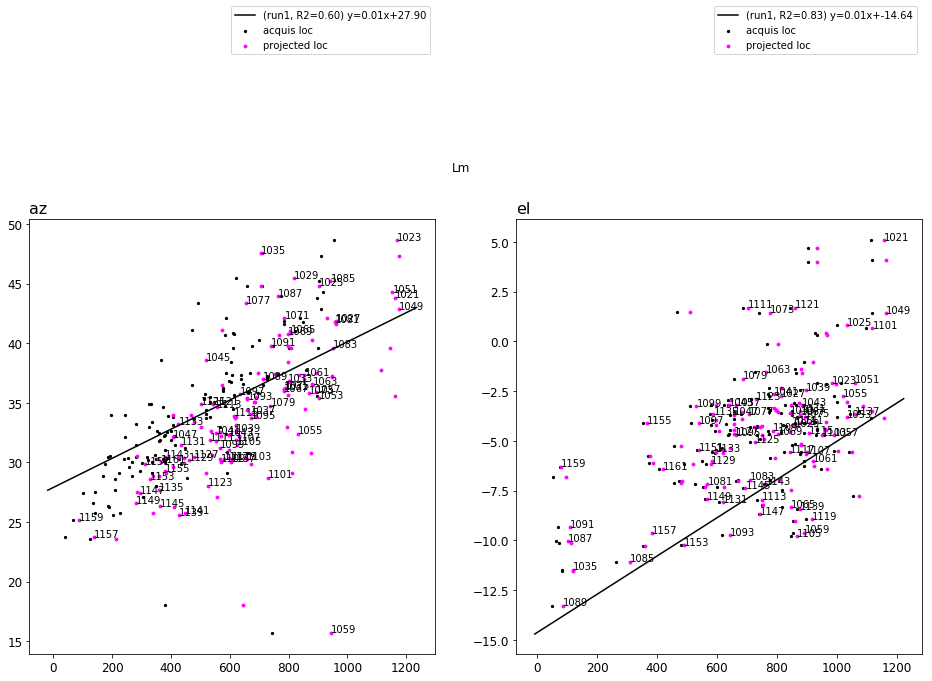

In [607]:
did_above=True
datakey = '20190622_JC085_fov1' #'20190522_JC084_fov1' #'20190607_JC091_fov1'
retinorun = 'retino_run1'

rf_ = rfdf[rfdf['datakey']==datakey].copy()
ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]

#vhat_az = gresults['az']['vhat']
#vhat_el = gresults['el']['vhat']

fig, axn = pl.subplots(1,2, figsize=(16,8))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml' if cond=='az' else 'ap'
    yname = 'x0' if cond=='az' else 'y0'
    vhat_ = vhat_az if cond=='az' else vhat_el
    if did_above:
        ret_ = ret_az[~np.isnan(ret_az)] if cond=='az' else ret_el[~np.isnan(ret_el)]
        regr_ = regr_az if cond=='az' else regr_el
        fitv_ = fitv_az if cond=='az' else fitv_el
    #print(cond, vhat_)
    
    cell_locs = rf_['%s_pos' % xname].values
    rf_locs = rf_['%s' % yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='acquis loc')

    #proj_locs = rfdf[rfdf['datakey']==datakey]['%s_proj' % xname].values
    #ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='dodgerblue')    
    
    # Plot projected points, not abs
    proj_locs2 = np.array([np.dot(np.array((ml, ap)), vhat_) \
                          for ap, ml in rf_[['ap_pos', 'ml_pos']].values])
    ax.scatter(proj_locs2, rf_locs, marker='o', s=8, color='magenta', label='projected loc')   
    
    # Label cells
    label_int=2
    for ri, cellid in enumerate(rf_.index.tolist()[0::label_int]):
        ax.text(proj_locs2[0::label_int][ri], rf_locs[0::label_int][ri], cellid)

    # Plot retino direction
    if did_above:
        slope = float(regr_.coef_) 
        intercept = float(regr_.intercept_) 
        r2_v = skmetrics.r2_score(ret_, fitv_) 
    else:
        slope = float(ret_[ret_['cond']==cond]['coefficient'])
        intercept = float(ret_[ret_['cond']==cond]['intercept'])
        r2_v = float(ret_[ret_['cond']==cond]['R2'])
    label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)
    ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix)

   #ax.invert_yaxis()
    ax.set_title(cond, loc='left', size=16)
    ax.legend(bbox_to_anchor=(1.,1.5))
    
pl.suptitle(currvs['visual_area'].unique()[0])

# Filter dfs: Only include dsets with both retino + rfs/rfs10 measured.
#### Also filter retino gradient df to only include dsets that have good fits (i.e., R2 > thr means retino direction well enough estimated or consistent enough to get a good projection)
NOTE:  TODO, check bad-fit retino dsets, since these may be split FOVs

In [72]:
common_datakeys = np.intersect1d(projection_df['datakey'].unique(), r_df['datakey'].unique())

In [73]:
# pass_regr_datakeys = projdf['datakey'].unique()
#rfdf = df[df['datakey'].isin(pass_regr_datakeys)].copy()
rfdf = r_df[r_df['datakey'].isin(common_datakeys)].copy()
print("RFs:")
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

projdf = projection_df[projection_df['datakey'].isin(common_datakeys)].copy()
print("retinogradients:")
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

RFs:
             datakey
visual_area         
Li                 5
Lm                 6
V1                 6
retinogradients:
             datakey
visual_area         
Li                 5
Lm                 6
V1                 6


In [77]:
projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) and (g[g['cond']=='el']['R2'].values > r2_thr))])
print("retinogradients (filt):")
print(projdf_filtered[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

retinogradients (filt):
             datakey
visual_area         
Li                 1
Lm                 4
V1                 3


In [78]:
r2_thr

0.5

#### Drop Repeats, cortical mag - paired

V1: (t-stat:-2.21, p=0.16)
Lm: (t-stat:-4.12, p=0.03)
Li: (t-stat:nan, p=nan)
cortical_mag_paired__drop_repeats_R2-0.50_npmean_thr-0.100


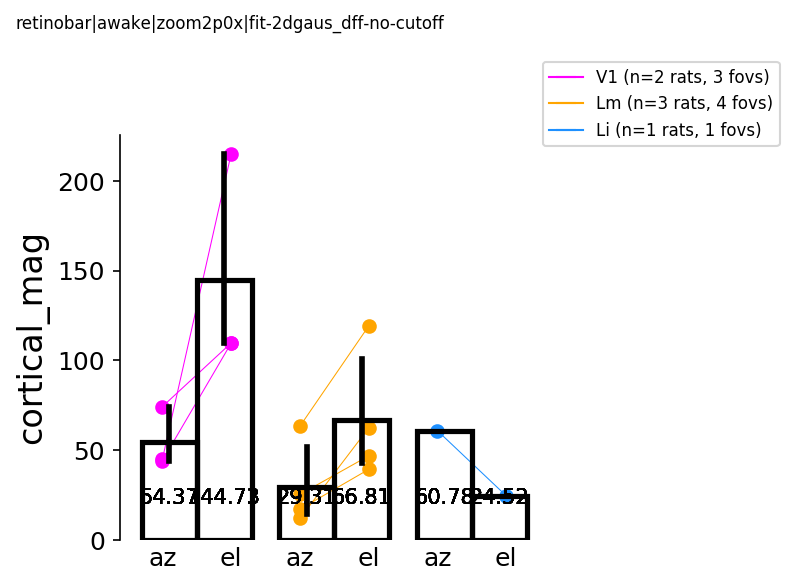

In [80]:
meitrc = 'abs_coef' 

plotdf = projdf_filtered.copy()
fig = plot_pairwise_by_axis(plotdf, curr_metric=metric, c1='az', c2='el',
                           area_colors=area_colors)
pl.subplots_adjust(left=0.15, right=0.7, top=0.8)
label_figure(fig, data_id)

#ax.set_ylim([0, 0.1])
figname = '%s_paired__%s_%s_%s' % (metric, filter_by, fit_str, magthr_str)
#pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))
print(figname)

#### Drop Repeats, cortical mag - any (not paired)

In [81]:
projdf_filtered = pd.concat([g for (datakey, retinorun), g in projdf.groupby(['datakey', 'retinorun']) \
            if ((g[g['cond']=='az']['R2'].values > r2_thr) or (g[g['cond']=='el']['R2'].values > r2_thr))])

cortical_mag_any__drop_repeats_R2-0.50_magthr-0.100-npmean


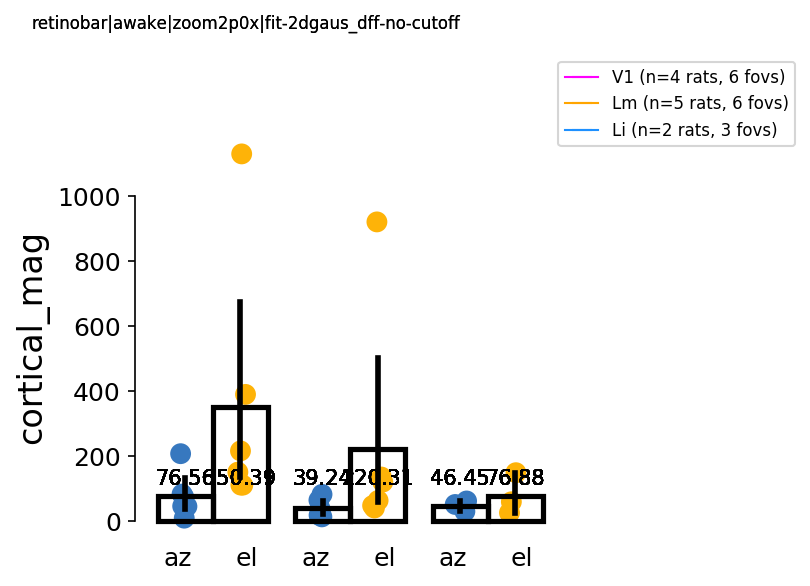

In [84]:
plotdf = projdf_filtered.copy()

metric='cortical_mag'
hue='cond'
currcols = ['windows blue', 'amber']
fig = plot_axis_distributions(plotdf, currmetric=metric, hue=hue,
                            currcols=currcols, area_colors=area_colors)
pl.subplots_adjust(left=0.15, right=0.7, top=0.8)
label_figure(fig, data_id)

#ax.set_ylim([0, 0.1])
figname = '%s_any__%s_%s_magthr-%.3f-%s' % (metric, filter_by, fit_str, mag_thr,pass_criterion)
#pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))
print(figname)

# Get projected ctx positions

In [780]:
for di, ((datakey, exp), rd) in enumerate(rfdf.groupby(['datakey', 'experiment'])):
    print(di)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [781]:
len(rfdf.groupby(['datakey', 'experiment']).groups)


39

In [85]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((datakey, exp), rd) in enumerate(rfdf.groupby(['datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))
        
    retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    p_df = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % magthr_str)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])

1 of 22 gradient result files loaded.
11 of 22 gradient result files loaded.
21 of 22 gradient result files loaded.
22 of 22 gradient result files loaded.


In [86]:
print(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
# projdf.groupby(['visual_area', 'datakey', 'cond']).mean()

             datakey
visual_area         
Li                 5
Lm                 6
V1                 6


In [87]:
print(projdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                 5
Lm                 6
V1                 6


## Plot az/el per session, for 1 FOV (rfs or rfs10, best retino)

In [88]:
by_session_dir = os.path.join(aggr_retino_dir, 'gradient_analysis', 'by_session')
if not os.path.exists(by_session_dir):
    os.makedirs(by_session_dir)

print(data_id)

retinobar|awake|zoom2p0x|fit-2dgaus_dff-no-cutoff


In [89]:
def plot_retino_scatter_by_fov(vdf, projdf, cond_colors=['blue', 'orange'], cond_names=['az', 'el'],
                            markersize=10, col_wrap=6):
    n_fovs = len(vdf['datakey'].unique())
    n_subplots = n_fovs*2
    n_rows = int(np.ceil(n_subplots/float(col_wrap))) #nsubplots % col_wrap

    fig, axn = pl.subplots(n_rows, col_wrap, figsize=(col_wrap*3, n_rows*4))
    ai=0
    for datakey, rfs_ in vdf.groupby(['datakey']):
        for ci, (col, cond) in enumerate(zip(cond_colors, cond_names)):
            ax = axn.flat[ai]
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'

            # Get RF fit info
            cell_locs = rfs_['%s_pos' % xname].values
            proj_locs = rfs_['%s_proj' % xname].values
            rf_locs = rfs_[yname].values

            # Plot RF pos
            ax.scatter(cell_locs, rf_locs, marker='o', s=markersize, color='k')

            # Plot projected
            ax.scatter(proj_locs, rf_locs, marker='o', s=markersize, color=col)

            # Plot retino direction
            # Get best retino run, in case there is > 1
            retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
            ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()

            slope = float(ret_[ret_['cond']==cond]['coefficient'])
            intercept = float(ret_[ret_['cond']==cond]['intercept'])
            ls = ':' if float(ret_[ret_['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(ret_[ret_['cond']==cond]['R2'])
            label_prefix = '%s, R2=%.2f' % (cond, r2_v) #(retinorun.split('_')[-1], r2_v)
            # label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix, ls=ls)
            if ci==0:
                ax.set_title(datakey, fontsize=20, loc='left')
            ai += 1
            ax.legend(loc='bottom') #bbox_to_anchor=(0.5, -0.1))
            
    for a in np.arange(ai, (n_rows*col_wrap)):
        axn.flat[a].axis('off')
        
    return fig


('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/by_session', 'scatter_Li_rfs__drop_repeats_npmean_thr-0.100')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/by_session', 'scatter_Lm_rfs__drop_repeats_npmean_thr-0.100')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/by_session', 'scatter_V1_rfs__drop_repeats_npmean_thr-0.100')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/by_session', 'scatter_Li_rfs10__drop_repeats_npmean_thr-0.100')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/by_session', 'scatter_Lm_rfs10__drop_repeats_npmean_thr-0.100')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/gradient_analysis/by_session', 'scatter_V1_rfs10__drop_repeats_npmean_thr-0.100')


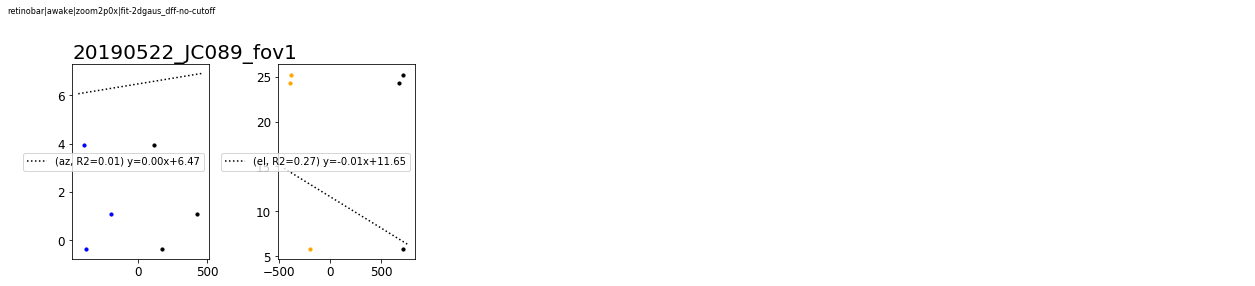

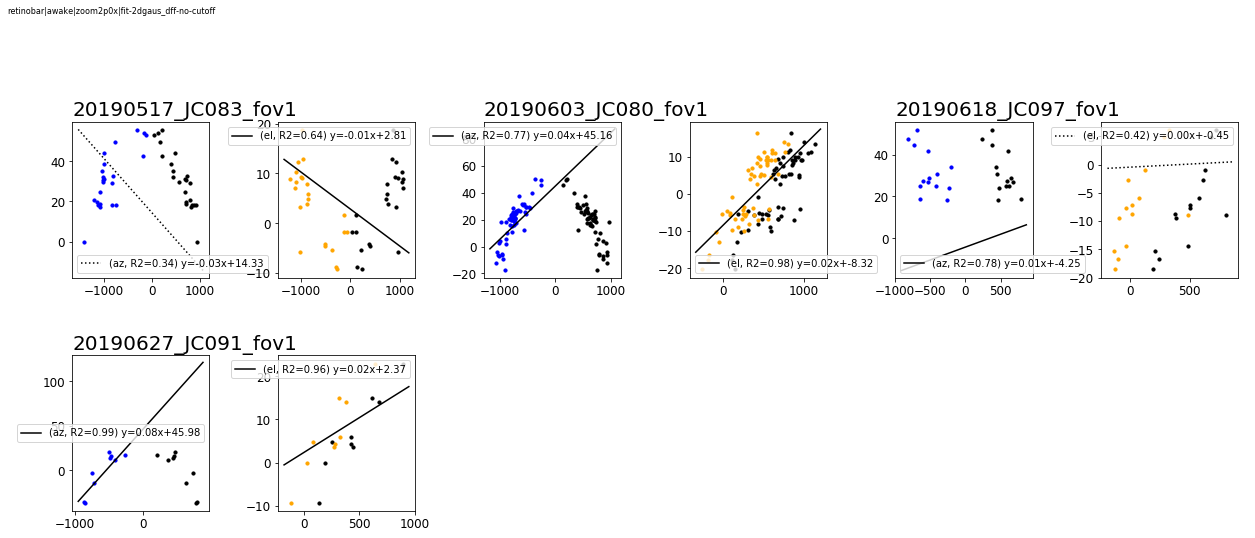

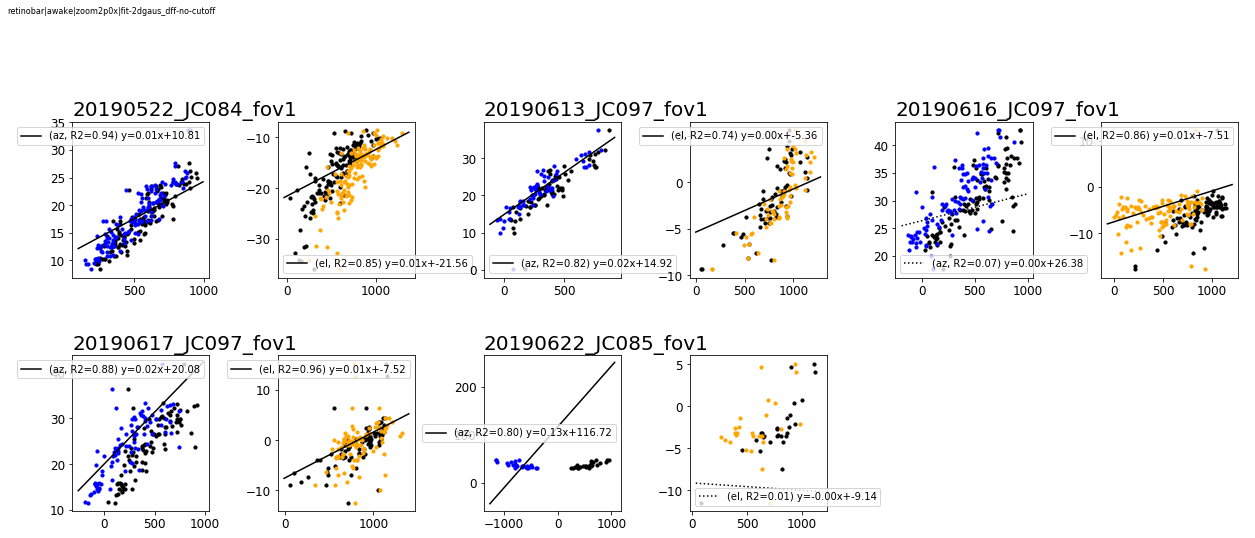

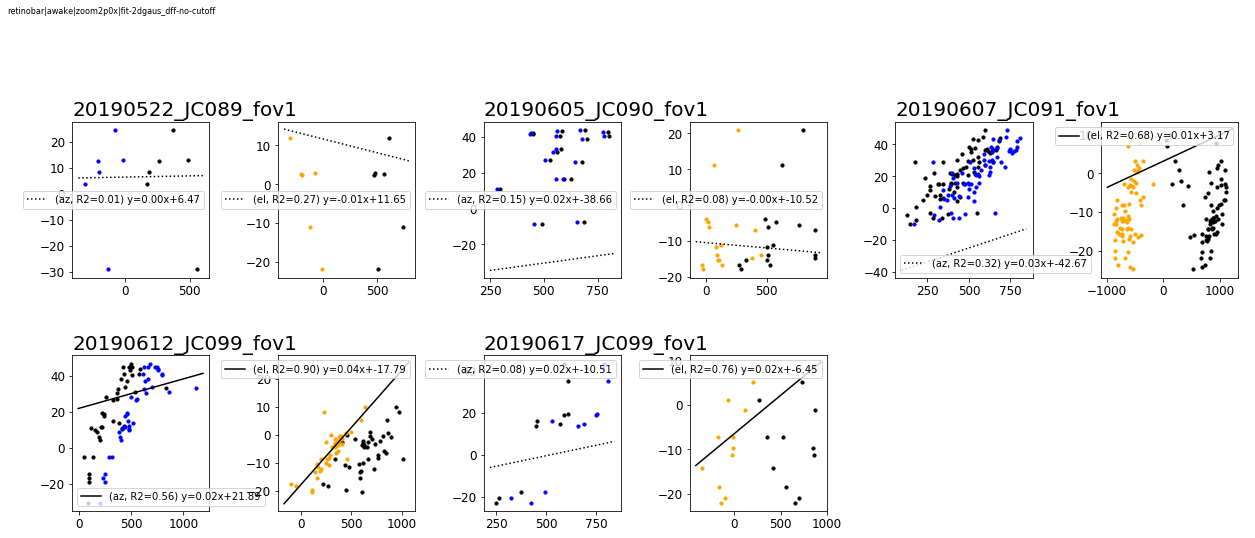

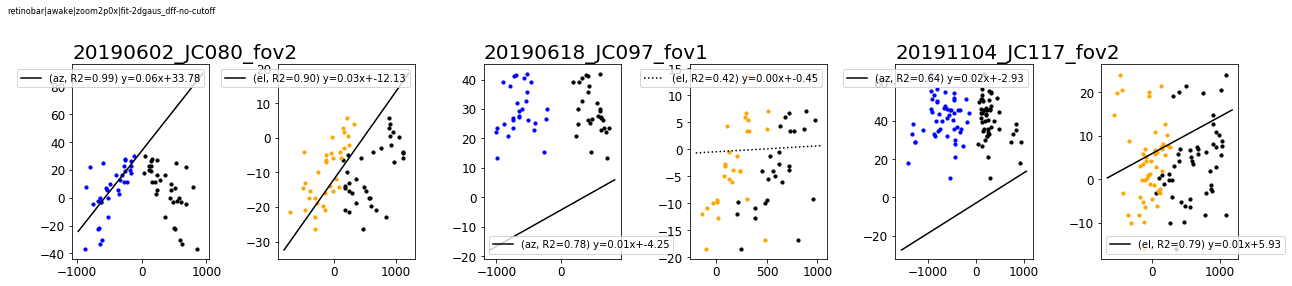

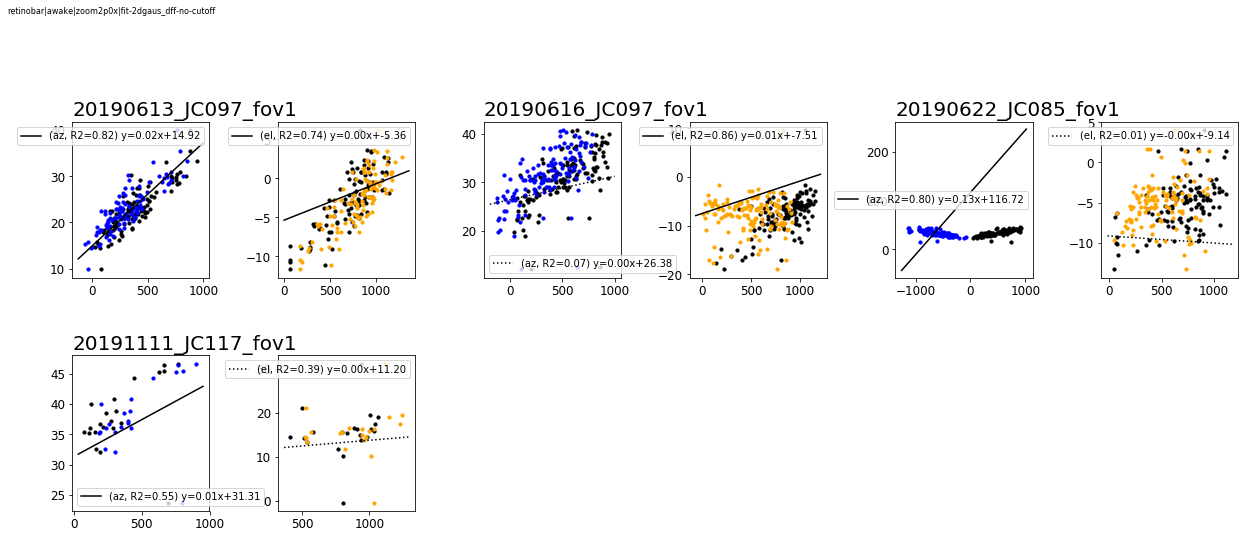

In [90]:
col_wrap = 6
cond_names = ['az', 'el']
cond_colors = ['blue', 'orange']
markersize = 10

for rfname, rfdf_exp in rfdf.groupby(['experiment']):
    for visual_area, rfdf_vis in rfdf_exp.groupby(['visual_area']): #['V1', 'Lm', 'Li']:

        curr_fig_title = '%s: RFS (%s), Retino (magthr-%.3f)' % (visual_area, rfname, mag_thr)

        fig = plot_retino_scatter_by_fov(rfdf_vis, projdf, cond_colors=cond_colors, cond_names=cond_names,
                                    markersize=markersize, col_wrap=col_wrap)

        label_figure(fig, data_id)   
        pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.05, right=0.95)

        figname = 'scatter_%s_%s__%s_%s' % (visual_area, rfname, filter_by, magthr_str) 
        pl.savefig(os.path.join(by_session_dir, '%s.svg' % figname))

        print(by_session_dir, figname)

In [792]:
mag_thr

0.015

# Aggregate scatter metrics

In [793]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)



In [839]:
screen

{'altitude_deg': 67.323,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

In [840]:
d1, d2

(1177, 972)

In [853]:
rfname = 'rfs10'
rfdf_exp = rfdf[rfdf['experiment']==rfname].copy()

min_ncells=5

not_enough_cells_fit = []
bad_fits = []
d_list = []
for (visual_area, datakey), rfs_ in rfdf_exp.groupby(['visual_area','datakey']): #['V1', 'Lm', 'Li']:
    if rfs_.shape[0] < min_ncells:
        not_enough_cells_fit.append(datakey)
        continue
        
    # Get retino gradient
    retinorun = projdf[projdf['datakey']==datakey].groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
    ret_ = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)].copy()

    for cond, ret_cond in ret_.groupby(['cond']):
        xname = 'ml' if cond=='az' else 'ap'
        yname = 'x0' if cond=='az' else 'y0'
        max_degrees = screen['azimuth_deg'] if cond=='az' else screen['altitude_deg']
        max_fovdist = 1177 if cond=='ap' else 972.
        
        # Get RF fit info
        proj_locs = np.array(rfs_['%s_proj' % xname].values)
        rf_locs = np.array(rfs_[yname].values)

        # Get dist to line:
        slope = float(ret_cond['coefficient'])
        intercept = float(ret_cond['intercept'])
        r2 = float(ret_cond['R2'])
        predicted_rf_locs = slope*proj_locs + intercept

        deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
        deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees]
        dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
        dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist]
        keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
        n_pts = len(keep_ixs)
        if (n_pts)==0:
            bad_fits.append((datakey, cond))
            continue
            
        if any(np.isnan(dist_sc)):
            print(visual_area, datakey, r2)
        if any(np.isnan(deg_sc)):
            print(visual_area, datakey, r2)
        tmpd=pd.DataFrame({'deg_scatter': deg_sc[keep_ixs],
                           'dist_scatter': dist_sc[keep_ixs],
                           'measured_rf': rf_locs[keep_ixs],
                           'predicted_rf': predicted_rf_locs[keep_ixs],
                           'measured_loc': proj_locs[keep_ixs],
                           'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                           'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                           'axis': [cond for _ in np.arange(0, n_pts)],
                           'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                           'datakey': [datakey for _ in np.arange(0, n_pts)]
                     })
        d_list.append(tmpd)
scatdf = pd.concat(d_list, axis=0)
print(scatdf.shape)
scatdf.head()


(1789, 10)


,axis,datakey,deg_scatter,dist_scatter,measured_loc,measured_rf,predicted_loc,predicted_rf,retino_R2,visual_area
0,az,20190522_JC089_fov1,33.355265,741.442165,734.692,-29.065480,-6.750410,4.28979,0.952952,Li
1,az,20190522_JC089_fov1,14.974824,332.869969,600.959,13.248381,933.829142,-1.72644,0.952952,Li
2,az,20190522_JC089_fov1,31.530479,700.879660,483.489,24.519398,1184.368527,-7.01108,0.952952,Li
3,az,20190522_JC089_fov1,23.307614,518.096549,400.154,12.547553,918.250698,-10.7601,0.952952,Li
4,az,20190522_JC089_fov1,17.950126,399.006884,322.98,3.718242,721.987120,-14.2319,0.952952,Li


In [854]:
print("Not enough cells passed RF fit:", not_enough_cells_fit)
print("Bad fits for predicted pos/rf:", bad_fits)

('Not enough cells passed RF fit:', ['20191111_JC120_fov1', '20191111_JC117_fov2'])
('Bad fits for predicted pos/rf:', [('20190522_JC089_fov1', 'el')])


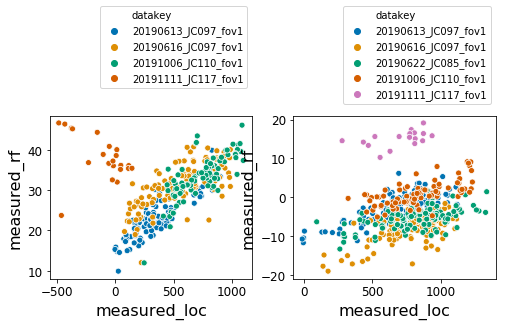

In [855]:
retino_thr = 0.7
plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()
sns.set_palette('colorblind')
fig, axn = pl.subplots(1,2, figsize=(8,3))
visual_area = 'V1'

vdf = plotdf[plotdf['visual_area']==visual_area]

for ax, (cond, vdf_ax) in zip(axn.flat, vdf.groupby(['axis'])):

    sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                    hue='datakey')
    
    ax.legend(bbox_to_anchor=(1., 1.7))

In [871]:
retino_thr = 0.9
#plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

mean_values = scatdf[scatdf['retino_R2']>retino_thr].groupby(['visual_area', 'datakey', 'axis']).mean().reset_index()
mean_values.head()

print(mean_values.shape)
print(mean_values[mean_values['retino_R2']>0.9].shape)

(13, 8)
(13, 8)


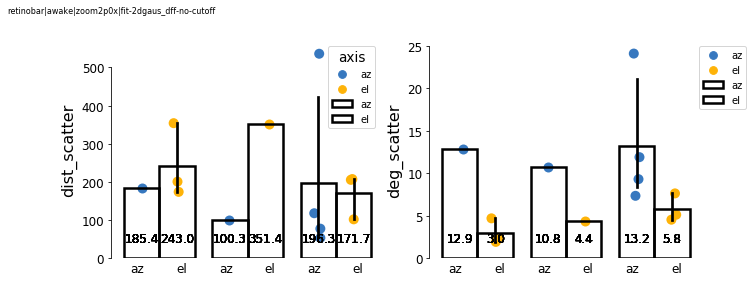

In [872]:
#plotdf = mean_values[mean_values['retino_R2']>retino_thr].copy()
plotdf = mean_values.copy()

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):

    sns.stripplot(x='visual_area', y=plotter, hue='axis', data=plotdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                  order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", plotter, data=plotdf, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')

    #if plotter=='dist_scatter':
    #    ax.set_ylim([0, 1200])
    
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)
pl.legend(bbox_to_anchor=((1.2, 1)))
pl.subplots_adjust(right=0.8)


aggr_scatter_fovmeans_retinothr-0.50_drop_repeats_magthr-0.01


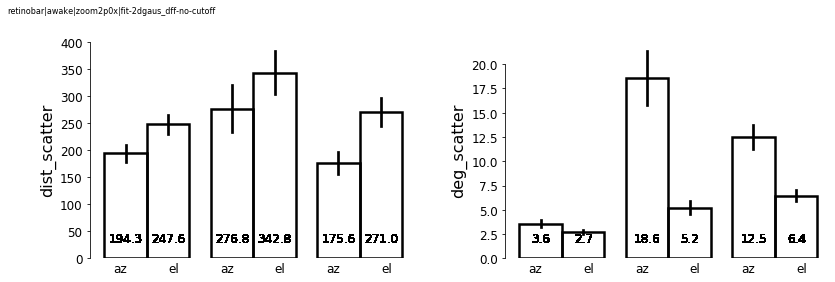

In [884]:
retino_thr = 0.5
plot_cells=False

plotdf = scatdf[scatdf['retino_R2']>retino_thr].copy()

points_str = '' if plot_cells else 'fovmeans'

fig, axn = pl.subplots(1,2, figsize=(12,4))
for ax, plotter in zip(axn.flat, ['dist_scatter', 'deg_scatter']):

    if plot_cells:
        sns.stripplot(x='visual_area', y=plotter, hue='axis', data=plotdf, 
                      dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                      order=['V1', 'Lm', 'Li'])
    #if barplot:
    sns.barplot("visual_area", plotter, data=plotdf, ax=ax,
               hue='axis', order=visual_areas, errcolor="k",
               edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    change_width(ax, .4)

    plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fmt='%.1f')
    rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
    ax.legend_.remove()
    
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)
#pl.legend(bbox_to_anchor=((1.2, 1)))
pl.subplots_adjust(right=0.8)

pl.subplots_adjust(wspace=0.3, left=0.1, right=0.95)    
# # Set x labels
# rfutils.set_split_xlabels(ax, a_label='az', b_label='el')
# ax.set_ylabel('rate of retinotopic change (deg/um)', fontsize=12)    

figname = 'aggr_scatter_%s_retinothr-%.2f_%s_magthr-%.3f' % (points_str, retino_thr, filter_by, mag_thr)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis', '%s.svg' % figname))
print(figname)

In [863]:
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

Text(0.5,0.98,u'20190613_JC097_fov1')

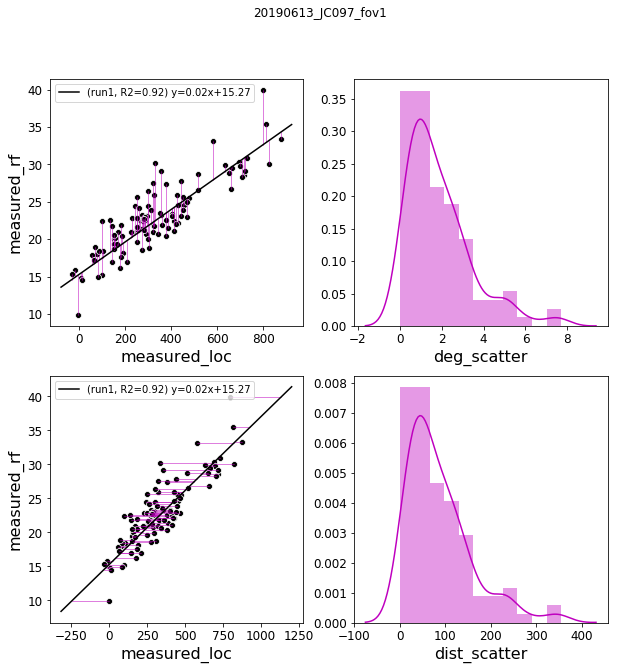

In [679]:
datakey = '20190613_JC097_fov1'
vdf = plotdf[plotdf['datakey']==datakey]
ret_ = projdf[projdf['datakey']==datakey]

fig, axn = pl.subplots(2,2, figsize=(10,10))
cond='az'
vdf_ax = vdf[vdf['axis']==cond]
ax = axn[0, 0]
sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                color='k')
slope = float(ret_[ret_['cond']==cond]['coefficient'])
intercept = float(ret_[ret_['cond']==cond]['intercept'])
r2_v = float(ret_[ret_['cond']==cond]['R2'])
label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)

for ii, (xi, yi) in enumerate(vdf_ax[['measured_loc', 'measured_rf']].values):
    pred = vdf_ax['predicted_rf'].iloc[ii]
    offset = vdf_ax['deg_scatter'].iloc[ii]*-1 if yi>pred else vdf_ax['deg_scatter'].iloc[ii]
    ax.plot([xi,xi], [yi, yi+offset], 'm', alpha=1, lw=0.5)
ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix)

ax = axn[0, 1]
sns.distplot(vdf_ax['deg_scatter'], color='m', ax=ax)


ax = axn[1, 0]
sns.scatterplot(x='measured_loc', y='measured_rf', data=vdf_ax, ax=ax,
                color='k')
slope = float(ret_[ret_['cond']==cond]['coefficient'])
intercept = float(ret_[ret_['cond']==cond]['intercept'])
r2_v = float(ret_[ret_['cond']==cond]['R2'])
label_prefix='%s, R2=%.2f' % (retinorun.split('_')[1], r2_v)

for ii, (xi, yi) in enumerate(vdf_ax[['measured_loc', 'measured_rf']].values):
    pred = vdf_ax['predicted_loc'].iloc[ii]
    offset = vdf_ax['dist_scatter'].iloc[ii]*-1 if xi>pred else vdf_ax['dist_scatter'].iloc[ii]    
    ax.plot([xi, xi+offset], [yi, yi], 'm', alpha=1, lw=0.5)
ax = abline(slope, intercept, ax=ax, color='k', label=True, label_prefix=label_prefix)

ax = axn[1, 1]
sns.distplot(vdf_ax['dist_scatter'], color='m', ax=ax)


pl.suptitle(datakey)

In [671]:
vdf_ax.head()

,axis,datakey,deg_scatter,dist_scatter,measured_loc,measured_rf,predicted_loc,predicted_rf,retino_R2,visual_area
0,az,20190613_JC097_fov1,7.275521,334.964654,799.145,39.905866,1134.109349,32.6303,0.916572,V1
1,az,20190613_JC097_fov1,0.057691,2.656077,476.072,25.555434,473.416143,25.6131,0.916572,V1
2,az,20190613_JC097_fov1,5.233501,240.950155,582.386,33.155796,823.336450,27.9223,0.916572,V1
3,az,20190613_JC097_fov1,2.484759,114.398174,813.273,35.421968,927.670898,32.9372,0.916572,V1
4,az,20190613_JC097_fov1,0.984448,45.323960,877.478,33.347307,832.153616,34.3318,0.916572,V1


## Select best Retino, and either rfs/rfs10. Plot projected fov vs. orig fov position

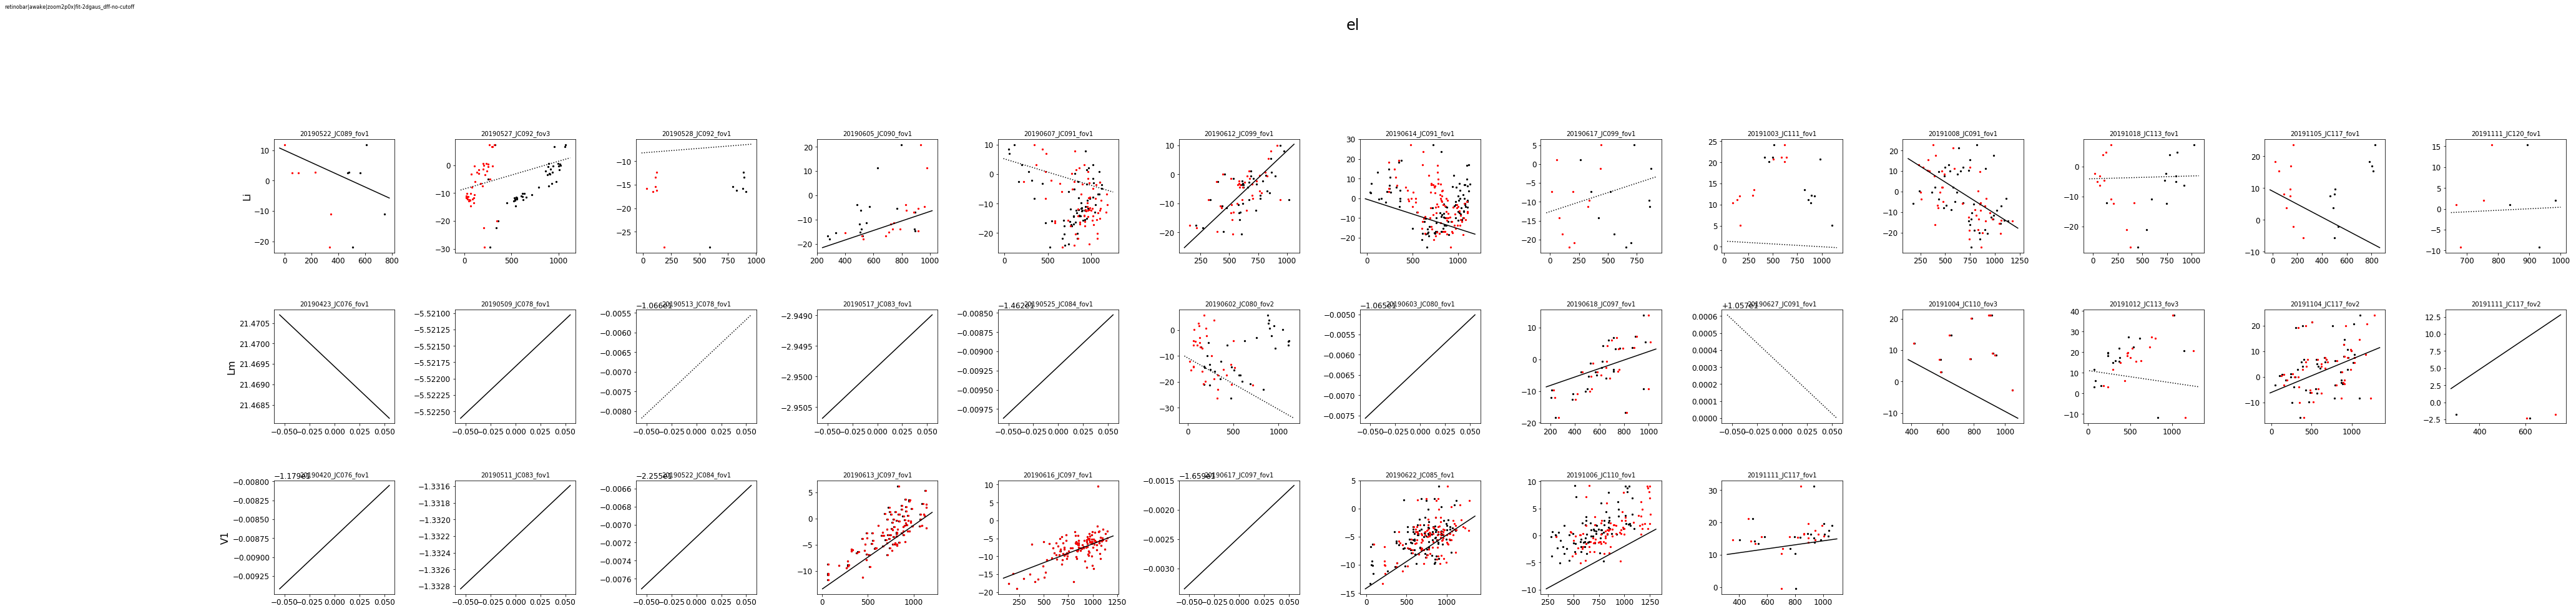

In [204]:
cond = 'el'
rfname = 'rfs10'
alt_rfname = 'rfs10' if rfname=='rfs' else 'rfs10'

rep_colors=['blue', 'orange']

xname = 'ml' if cond=='az' else 'ap'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(rfdf[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(rfdf.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):
        
        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        #for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

        # Plot RF positions vs. cell locs
        edf = ddf[ddf['experiment']==rfname].copy()
        if len(edf)==0:
            edf = ddf[ddf['experiment']==alt_rfname].copy()
            #rfname = alt_rfname
        
        cell_locs = edf['%s_pos' % xname].values
        rf_locs = edf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k')
        
        # plot projected
        cell_locs = edf['%s_proj' % xname].values
        rf_locs = edf[yname].values
        ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='r')

        # Plot retino direction
        p_df = projdf[projdf['datakey']==datakey]
        retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
        g = p_df[p_df['retinorun']==retinorun].copy()
        
        slope = float(g[g['cond']==cond]['coefficient'])
        intercept = float(g[g['cond']==cond]['intercept'])
        ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
        r2_v = float(g[g['cond']==cond]['R2'])
        label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(p_df)>2 else ''
        label = len(regdf_vs)>2
        ax = abline(slope, intercept, ax=ax, color='k',
                    label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
ax.legend()

pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = '%s_retinogradient_v_rfpos_v_fovpos_%s__%s_magthr-%.2f-%s' % (rfname, cond, filter_str, mag_thr, pass_criterion)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

## Plot all RFs and Retino Runs by session 

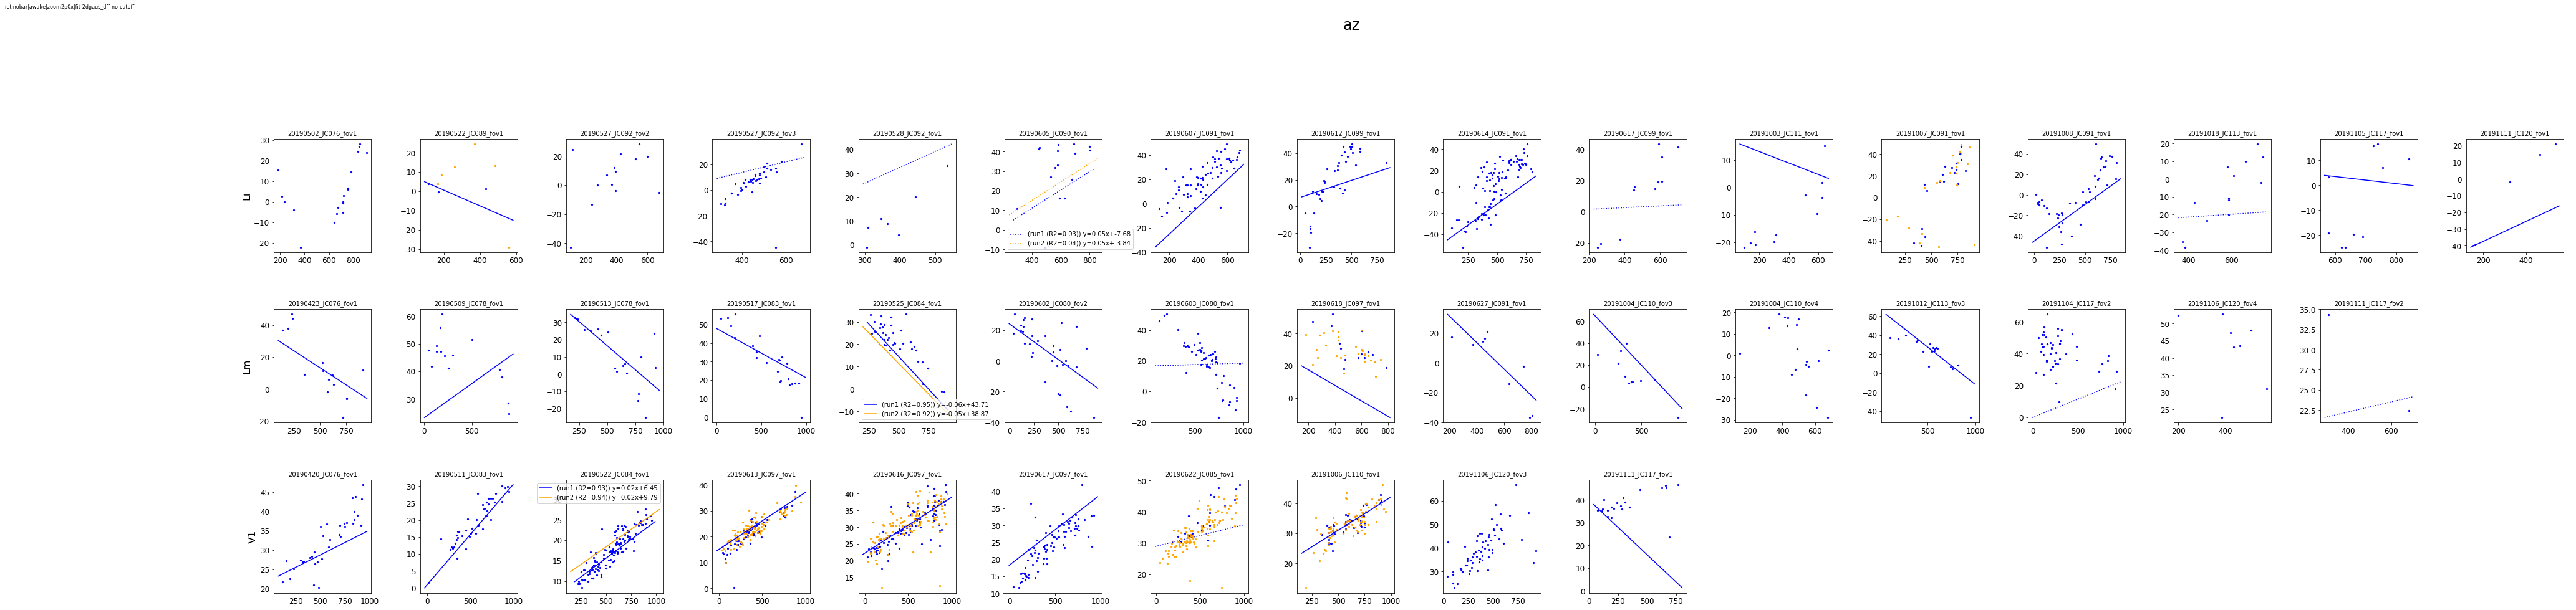

In [188]:
cond = 'az'
rep_colors=['blue', 'orange']

xname = 'ml_pos' if cond=='az' else 'ap_pos'
yname = 'x0' if cond=='az' else 'y0'
    
max_nfovs = int(r_df[['visual_area','datakey']].drop_duplicates().groupby(['visual_area']).count().max())

fig, axn = pl.subplots(3, max_nfovs, figsize=(60,15))
for ri, (visual_area, vdf) in enumerate(r_df.groupby(['visual_area'])):
    for ci, (datakey, ddf) in enumerate(vdf.groupby(['datakey'])):

        ax = axn[ri, ci]
        if ci==0:
            ax.set_ylabel(visual_area, fontsize=16)
        for col, (exp, edf) in zip(rep_colors, ddf.groupby(['experiment'])):

            # Plot RF positions vs. cell locs
            cell_locs = edf[xname].values
            rf_locs = edf[yname].values
            ax.scatter(cell_locs, rf_locs, marker='o', s=5, color=col)

        # Plot retino direction
        regdf_vs = projdf[projdf['datakey']==datakey]
        for col, (retinorun, g) in zip(rep_colors, regdf_vs.groupby(['retinorun'])):
            slope = float(g[g['cond']==cond]['coefficient'])
            intercept = float(g[g['cond']==cond]['intercept'])
            ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
            r2_v = float(g[g['cond']==cond]['R2'])
            label_prefix = '%s (R2=%.2f)' % (retinorun.split('_')[-1], r2_v) if len(regdf_vs)>2 else ''
            label = len(regdf_vs)>2
            ax = abline(slope, intercept, ax=ax, color=col,
                        label=label, label_prefix=label_prefix, ls=ls)
        ax.set_title(datakey, fontsize=10)
    
    if ci < (max_nfovs-1):
        for ci in np.arange(ci+1, max_nfovs):
            axn[ri, ci].axis('off')
ax.legend()

pl.subplots_adjust(left=0.1, wspace=0.5, hspace=0.5, right=0.95, top=0.8)
pl.suptitle(cond, fontsize=24)

label_figure(fig, data_id)

figname = 'inspect_retinogradient_v_rfpos_v_fovpos_%s__%s_magthr-%.2f-%s' % (cond, filter_str, mag_thr, pass_criterion)
pl.savefig(os.path.join(aggr_retino_dir, 'gradient_analysis','%s.svg' % figname))

In [189]:
projection_df[projection_df['datakey']=='20190607_JC091_fov1']

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef
0,0.973328,4.286557,0.111963,az,-47.418096,0.0,0.986574,JC091,20190607,FOV1_zoom2p0x,retino_run1,analysis002,20190607_JC091_fov1,/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...,Li,0.111963
1,0.418045,3.133284,-0.008981,el,5.184302,0.0,-0.646564,JC091,20190607,FOV1_zoom2p0x,retino_run1,analysis002,20190607_JC091_fov1,/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...,Li,0.008981


In [190]:
datakey = '20190607_JC091_fov1'
#retinorun = 'retino_run1'

p_df = projection_df[projection_df['datakey']==datakey]
# Load 1 fov to test sth
# fpath = [p for p in proj_fit_paths if p[0]=='JC091' and p[1]=='20190607' and p[3]==retinorun][0][5]
# with open(fpath, 'rb') as f:
#     res = pkl.load(f)
# print(res['regr_az'].coef_, res['regr_az'].intercept_)

# p_df = res['regr_df'].copy()


retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']
fpath = p_df[p_df['retinorun']==retinorun]['fpath'].unique()[0]
gpath = os.path.join(os.path.split(fpath)[0], 'gradients.pkl')
with open(gpath, 'rb') as f:
    gresults = pkl.load(f)

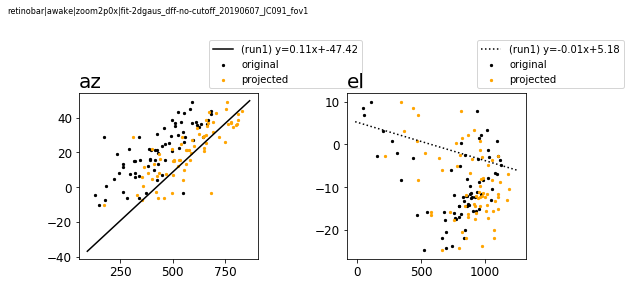

In [192]:
#datakey = '20190522_JC084_fov1' #'20190607_JC091_fov1'
#retinorun = 'retino_run1'
rfname = 'rfs10'

p_df = projdf[projdf['datakey']==datakey]
retinorun = p_df.groupby(['retinorun']).mean().reset_index()[['retinorun', 'R2']].max()['retinorun']

g = projdf[(projdf['datakey']==datakey) & (projdf['retinorun']==retinorun)]
edf = rfdf[(rfdf['datakey']==datakey) & (rfdf['experiment']==rfname)]

fig, axn = pl.subplots(1,2, figsize=(8,4))
for ax, cond in zip(axn.flat, ['az', 'el']):
    xname = 'ml' if cond=='az' else 'ap'
    yname = 'x0' if cond=='az' else 'y0'

    # Plot RF positions vs. cell locs
    cell_locs = edf['%s_pos' % xname].values
    rf_locs = edf[yname].values
    ax.scatter(cell_locs, rf_locs, marker='o', s=5, color='k', label='original')
    
    proj_locs = edf['%s_proj' % xname].values
    ax.scatter(proj_locs, rf_locs, marker='o', s=5, color='orange', label='projected')
    
    proj_locs2 = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
                             for ap, ml in edf[['ap_pos', 'ml_pos']].values]))


    # proj_locs = abs(np.array([np.dot(np.array((ml, ap)), gresults[cond]['vhat']) \
    #                           for ap, ml in edf[['ap_pos', 'ml_pos']].values]))
    #ax.scatter(proj_locs2, rf_locs, marker='o', s=5, color='blue')

    # plot gradient line
    slope = float(g[g['cond']==cond]['coefficient'])
    intercept = float(g[g['cond']==cond]['intercept'])
    ls = ':' if float(g[g['cond']==cond]['R2']) < r2_thr else '-'
    label_prefix = retinorun.split('_')[1]
    label = True
    ax = abline(slope, intercept, ax=ax, color='k',
                label=label, label_prefix=label_prefix, ls=ls)
    ax.set_title(cond, loc='left', fontsize=20)
    
    ax.legend(bbox_to_anchor=(0.7, 1), loc='top')
    
pl.subplots_adjust(top=0.7, wspace=0.5)

label_figure(fig, '%s_%s' % (data_id, datakey))

In [193]:
g

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r,animalid,session,fov,retinorun,retinoid,datakey,fpath,visual_area,abs_coef
0,0.973328,4.286557,0.111963,az,-47.418096,0.0,0.986574,JC091,20190607,FOV1_zoom2p0x,retino_run1,analysis002,20190607_JC091_fov1,/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...,Li,0.111963
1,0.418045,3.133284,-0.008981,el,5.184302,0.0,-0.646564,JC091,20190607,FOV1_zoom2p0x,retino_run1,analysis002,20190607_JC091_fov1,/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0...,Li,0.008981


In [630]:
proj_ = [np.dot(np.array((ap, ml)), gresults['el']['vhat']) for ap, ml in edf[['ap_pos', 'ml_pos']].values]



[1265.2474336870805,
 1306.7746604873687,
 1220.4113895819639,
 1111.3053426323288,
 1099.6193022330513,
 1093.6652739832678,
 1056.9476933257663,
 1015.6602439137907,
 990.40668755527713,
 1006.5293870488546,
 1019.7771998236738,
 1021.1258367429371,
 1081.1799756229473,
 988.56073457136483,
 997.45181404798802,
 975.52605725282399,
 901.64686373724146,
 879.57901663789187,
 754.36803148270235,
 726.79906897816022,
 589.01519999303241,
 505.23375455400378,
 719.83386828155369,
 862.66716079778098,
 878.95859252757896,
 784.69765330435064,
 747.82022105464046,
 758.15762453465459,
 903.43953285708426,
 699.47876450594276,
 670.07272966149981,
 725.92998683552287,
 709.92273571409578,
 673.12522926049019,
 648.16473415435871,
 674.66924034800832,
 638.00494355457636,
 573.33653270003447,
 532.19117359224447,
 523.50434892788769,
 464.78996632312948,
 444.19508515920552,
 473.66328451172956,
 281.61057266015501,
 720.26901983812149,
 627.64977878653906,
 787.87448191950318,
 739.54190601

In [610]:
float(g[g['cond']==cond]['intercept'])

6.461437259218765

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


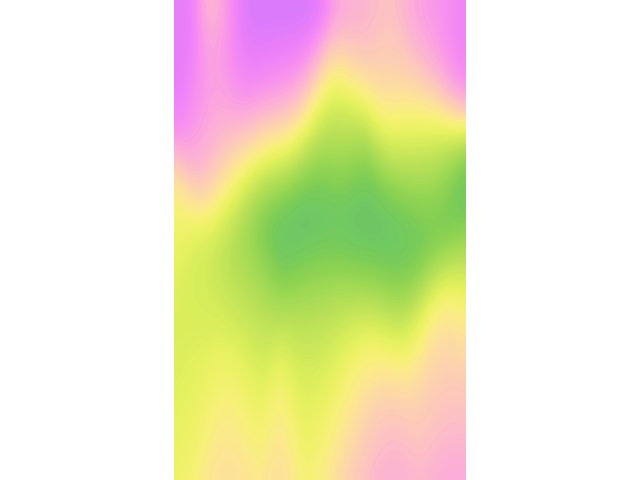

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

# Save legends